In [ ]:
import torch,random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from torchvision import transforms
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=180, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(1103, False)

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

xmean = tensor(0.28)
xstd = tensor(0.35)

@inplace
def transformi(b):
    b["image"] = [(TF.to_tensor(i) - xmean) / xstd for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 512
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

In [ ]:
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(accuracy=MulticlassAccuracy())]
init_w = partial(init_weights, leak=0.1)

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop):
    return tfm_x(b[0]), tfm_y(b[1])

## 5 epochs

In [ ]:
def get_model(act=act_gr, nfs=[16,32,64,128,256,512], norm=nn.BatchNorm2d):
    layers = [ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
    model = nn.Sequential(
        ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), *layers,
        nn.AdaptiveAvgPool2d(1), nn.Flatten(),
        nn.Linear(nfs[-1], 10), nn.BatchNorm1d(10)
    )
    return model

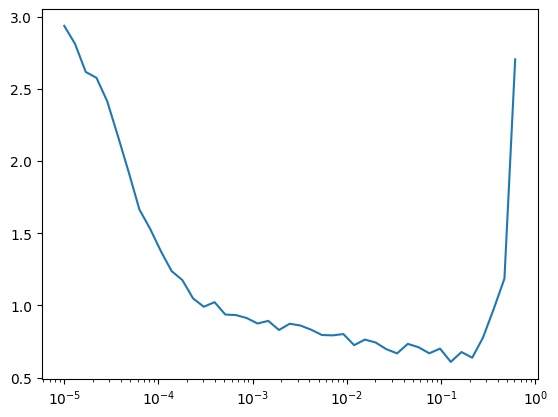

In [ ]:
set_seed(1103, False)
TrainLearner(get_model().apply(init_w), dls, F.cross_entropy, cbs=[DeviceCB()], opt_func=optim.AdamW).lr_find()

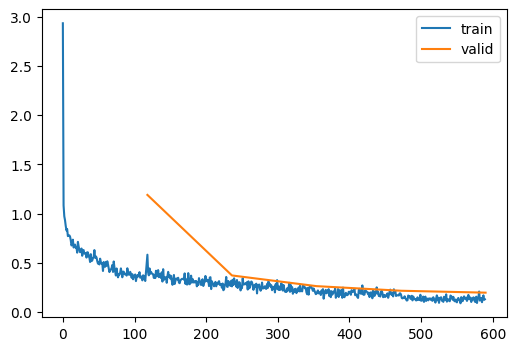

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model().apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=optim.AdamW)
learn.fit(epochs)

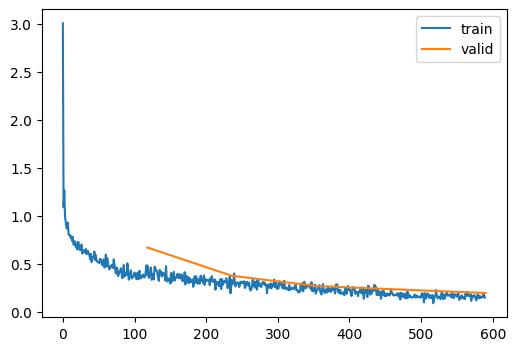

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip(),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model().apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment, sched], opt_func=optim.AdamW)
learn.fit(epochs)

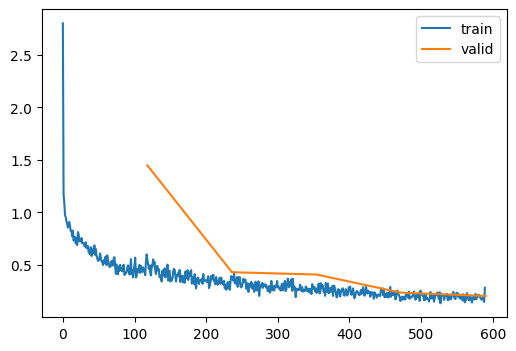

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model().apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment, sched], opt_func=optim.AdamW)
learn.fit(epochs)

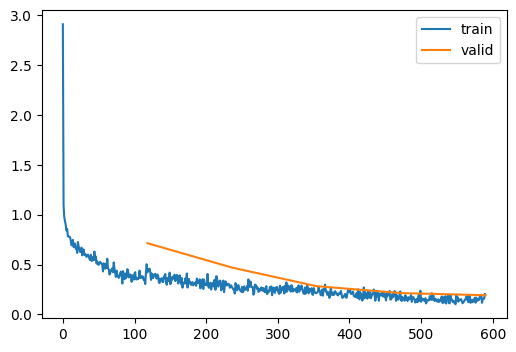

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    RandSwap(0.1, 2)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model().apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment, sched], opt_func=optim.AdamW)
learn.fit(epochs)

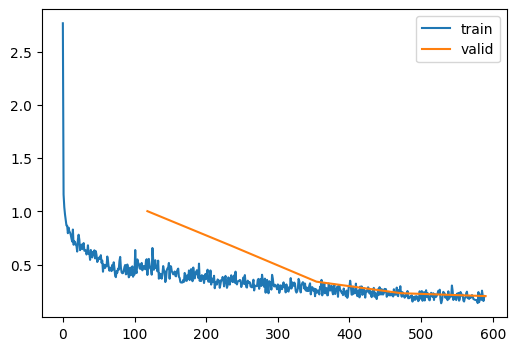

In [ ]:
epochs = 5
lr = 0.07
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    RandSwap(0.15, 3)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model().apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment, sched], opt_func=optim.AdamW)
learn.fit(epochs)

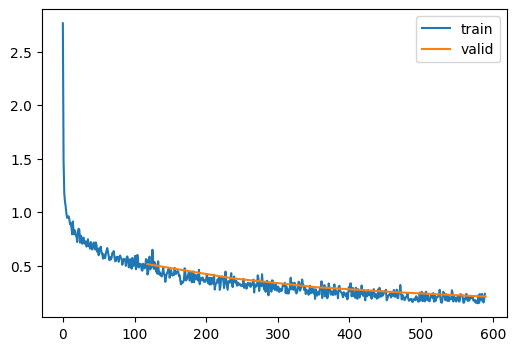

In [ ]:
epochs = 5
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    RandSwap(0.15, 3)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model().apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment, sched], opt_func=optim.AdamW)
learn.fit(epochs)

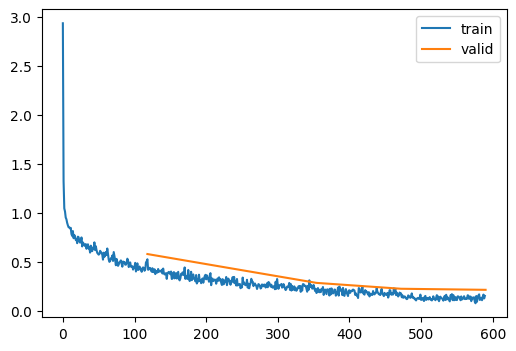

In [ ]:
epochs = 5
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model().apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=optim.AdamW)
learn.fit(epochs)

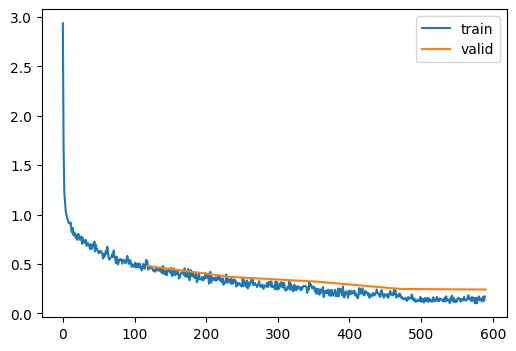

In [ ]:
epochs = 5
lr = 0.005
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model().apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=optim.AdamW)
learn.fit(epochs)

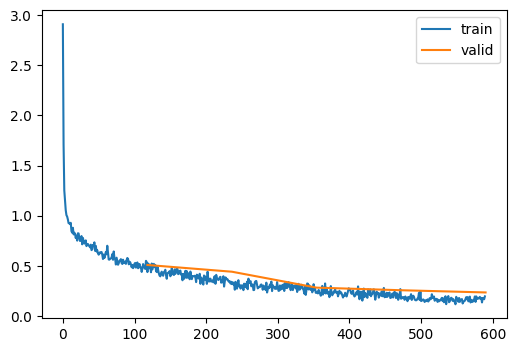

In [ ]:
epochs = 5
lr = 0.005
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    RandSwap(0.1, 2)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model().apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment, sched], opt_func=optim.AdamW)
learn.fit(epochs)

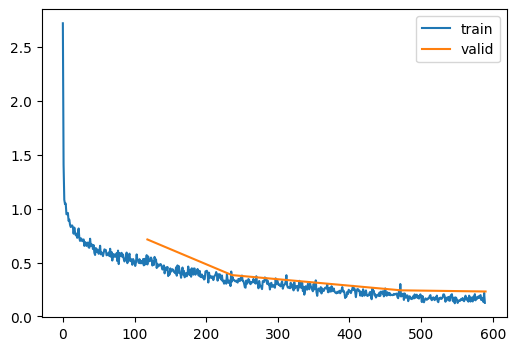

In [ ]:
epochs = 5
lr = 0.005
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    RandSwap(0.1, 2)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[16,32,64,128,256,512,1024]).apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment, sched], opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
def get_model(act=act_gr, nfs=[16,32,64,128,256,512], norm=nn.BatchNorm2d, init_zero=False):
    layers = [ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
    model = nn.Sequential(
        ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), *layers,
        nn.AdaptiveAvgPool2d(1), nn.Flatten(),
        nn.Linear(nfs[-1], 10), nn.BatchNorm1d(10)
    )
    if init_zero:
        for l in model[:-4]:
            init.zeros_(l.convs[-1][0].weight)
            init.zeros_(l.convs[-1][0].bias)
    else:
        model = model.apply(init_w)
    return model

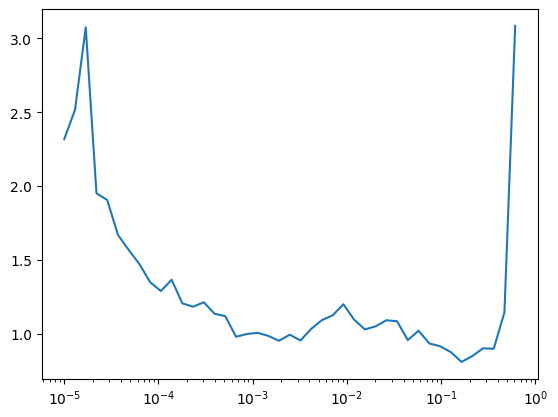

In [ ]:
epochs = 5
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
opt = partial(optim.AdamW, eps=1e-6, weight_decay=0.0)

set_seed(1103, False)
model = get_model(nfs=[16,32,64,128,256,512,1024], init_zero=True)
TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), augment], opt_func=opt).lr_find()

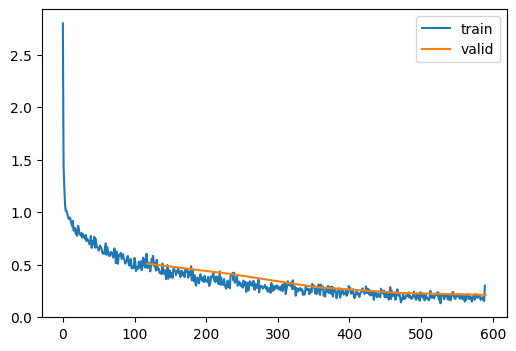

In [ ]:
epochs = 5
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
opt = partial(optim.AdamW, eps=1e-6, weight_decay=0.0)
stats = ActivationStats(lambda x: isinstance(x, nn.Conv2d) or isinstance(x, nn.Linear))

set_seed(1103, False)
model = get_model(nfs=[16,32,64,128,256,512], init_zero=False)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[stats, augment, sched], opt_func=opt)
learn.fit(epochs)

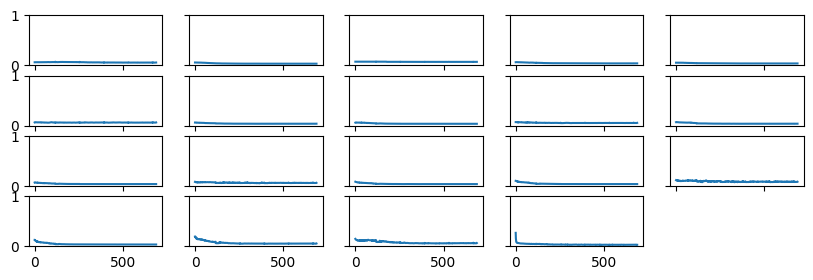

In [ ]:
stats.dead_chart()

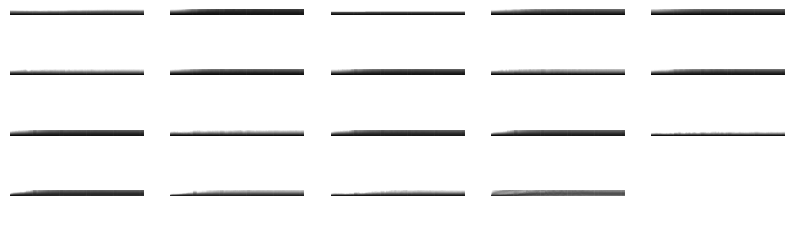

In [ ]:
stats.color_dim()

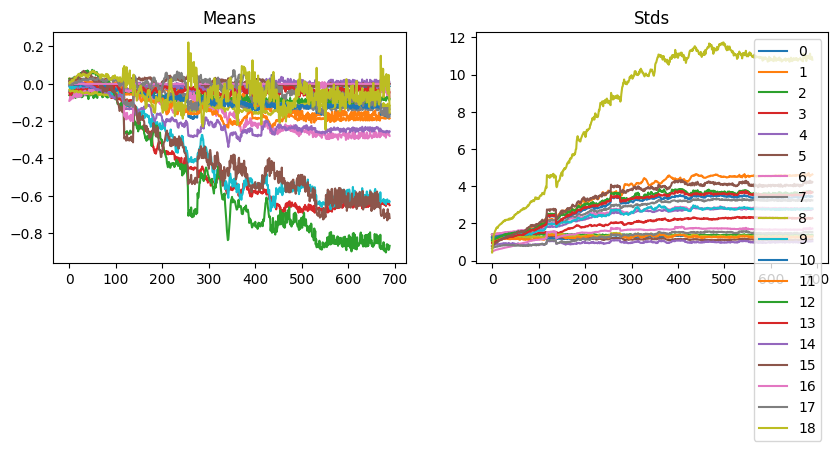

In [ ]:
stats.plot_stats()

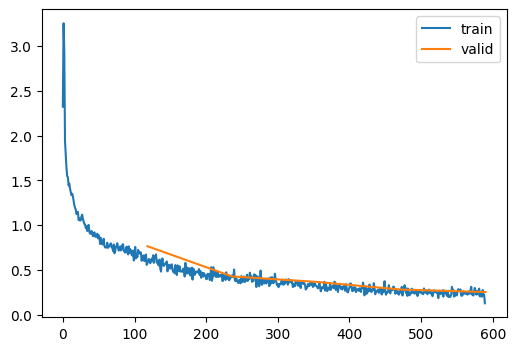

In [ ]:
epochs = 5
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
opt = partial(optim.AdamW, eps=1e-6, weight_decay=0.0)
stats = ActivationStats(lambda x: isinstance(x, nn.Conv2d) or isinstance(x, nn.Linear))

set_seed(1103, False)
model = get_model(nfs=[16,32,64,128,256,512], init_zero=True)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[stats, augment, sched], opt_func=opt)
learn.fit(epochs)

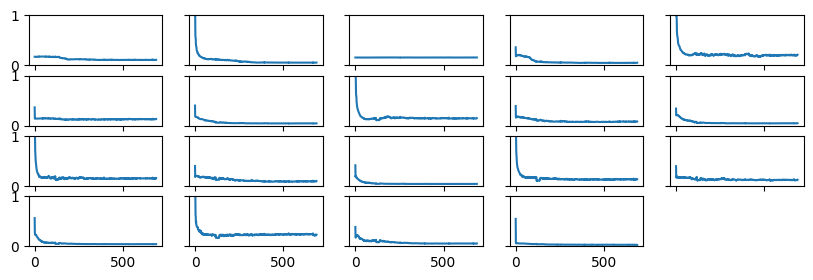

In [ ]:
stats.dead_chart()

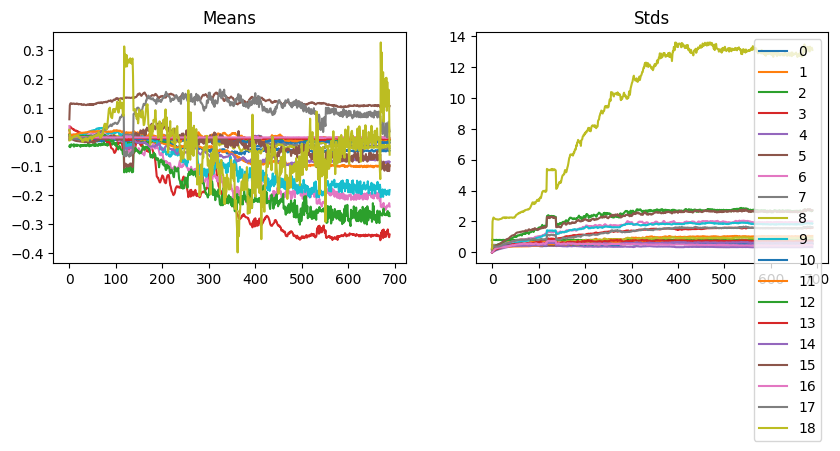

In [ ]:
stats.plot_stats()

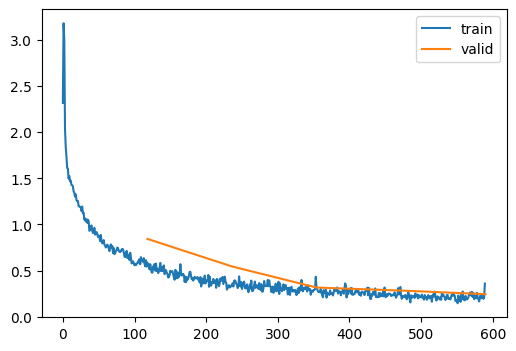

In [ ]:
epochs = 5
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
opt = partial(optim.AdamW, eps=1e-6, weight_decay=0.0)

set_seed(1103, False)
model = get_model(nfs=[16,32,64,128,256,512], init_zero=True)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=opt)
learn.fit(epochs)

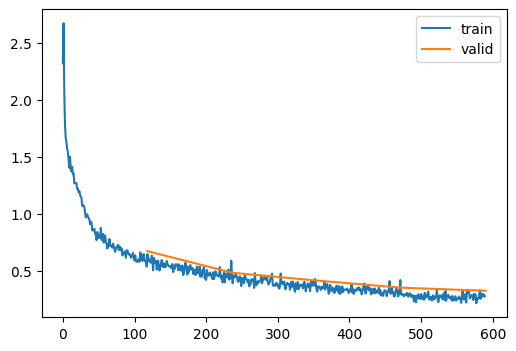

In [ ]:
epochs = 5
lr = 0.001
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
opt = partial(optim.AdamW, eps=1e-6, weight_decay=0.0)

set_seed(1103, False)
model = get_model(nfs=[16,32,64,128,256,512,1024], init_zero=True)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=opt)
learn.fit(epochs)

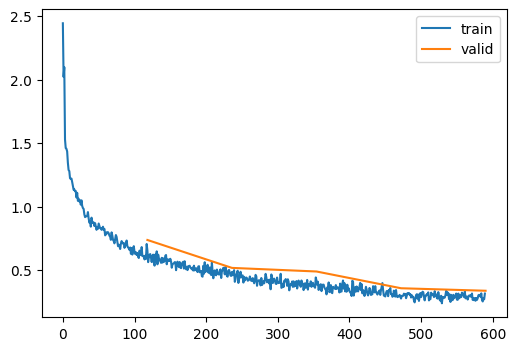

In [ ]:
epochs = 5
lr = 0.001
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
opt = partial(optim.AdamW, eps=1e-6, weight_decay=0.0)

set_seed(1103, False)
model = get_model(nfs=[16,32,64,128,256], init_zero=True)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=opt)
learn.fit(epochs)

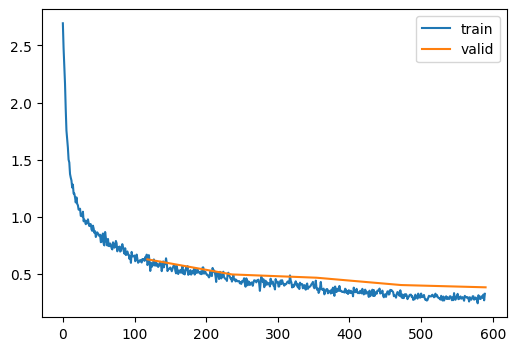

In [ ]:
epochs = 5
lr = 0.001
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
opt = partial(optim.AdamW, eps=1e-6, weight_decay=0.0)

set_seed(1103, False)
model = get_model(nfs=[16,32,64,128,256], init_zero=False)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=opt)
learn.fit(epochs)

In [ ]:
def get_model(act=act_gr, nfs=[16,32,64,128,256,512], norm=nn.BatchNorm2d, p_dropout=0.0, init_zero=False):
    layers = [ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
    layers.append(nn.AdaptiveAvgPool2d(1))
    layers.append(nn.Flatten())
    if p_dropout > 0.:
        layers.append(nn.Dropout(p=p_dropout))
    model = nn.Sequential(
        ResBlock(1, nfs[0], ks=5, stride=1, act=act, norm=norm), *layers,
        nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)
    )
    if init_zero:
        for l in model[:-5]:
            init.zeros_(l.convs[-1][0].weight)
            init.zeros_(l.convs[-1][0].bias)
    else:
        model = model.apply(init_w)
    return model

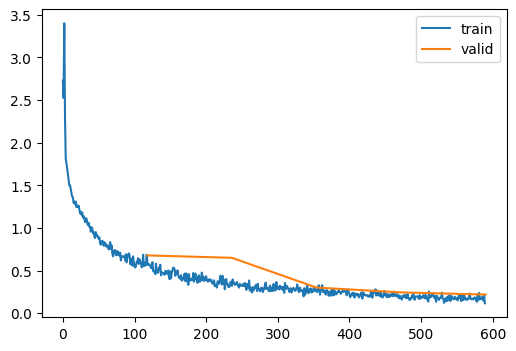

In [ ]:
epochs = 5
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
opt = partial(optim.AdamW, eps=1e-6, weight_decay=0.0)

set_seed(1103, False)
model = get_model(nfs=[16,32,64,128,256,512], init_zero=True, p_dropout=0.1)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=opt)
learn.fit(epochs)

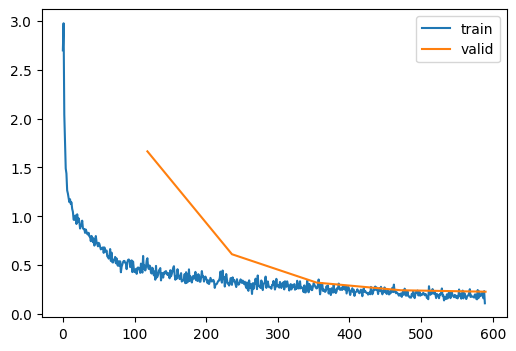

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
opt = partial(optim.AdamW, weight_decay=0.0)

set_seed(1103, False)
model = get_model(nfs=[16,32,64,128,256,512], init_zero=True)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=opt)
learn.fit(epochs)

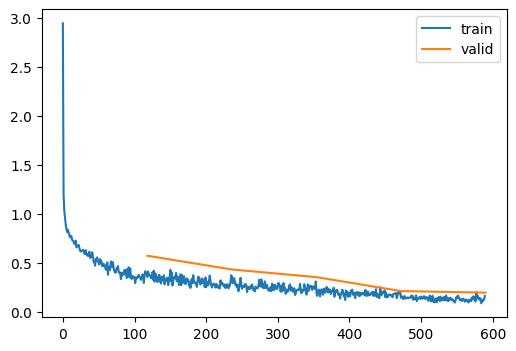

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
opt = partial(optim.AdamW, weight_decay=0.0)

set_seed(1103, False)
model = get_model(nfs=[16,32,64,128,256,512], init_zero=False)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=opt)
learn.fit(epochs)

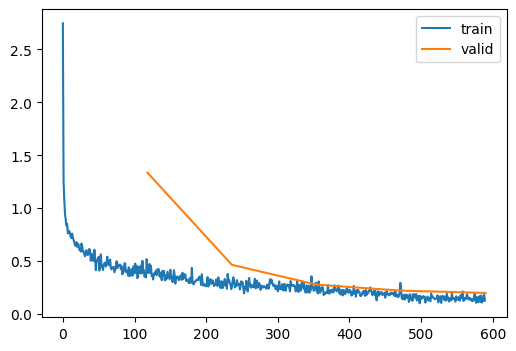

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    RandSwap(0.1, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[16,32,64,128,256,512,1024], init_zero=False)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

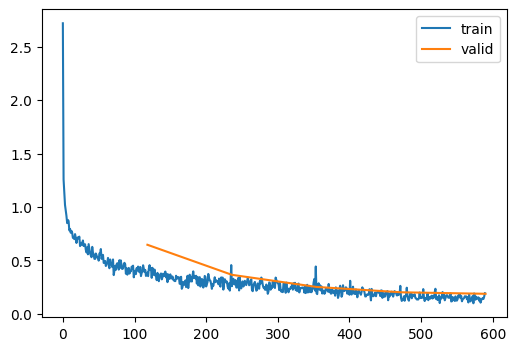

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    RandSwap(0.15, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[16,64,64,256,256,512,512], init_zero=False)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

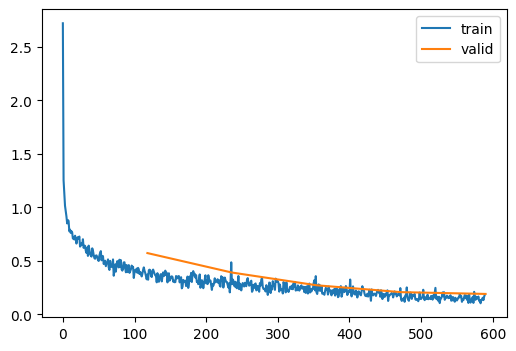

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    RandSwap(0.15, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[16,64,64,256,256,512,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

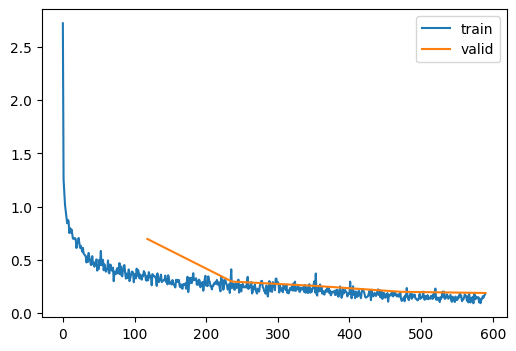

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.1))
transform = nn.Sequential(
    RandSwap(0.15, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[16,64,64,256,256,512,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

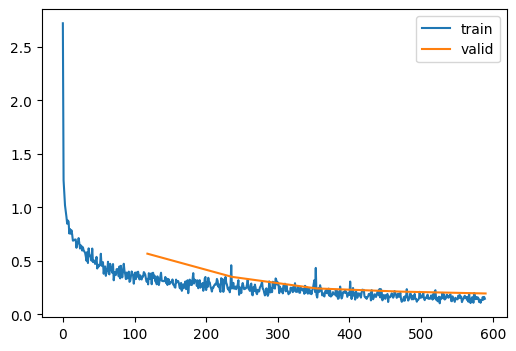

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.1, max_momentum=0.99))
transform = nn.Sequential(
    RandSwap(0.15, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[16,64,64,256,256,512,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=partial(optim.AdamW, betas=(0.99, 0.999)))
learn.fit(epochs)

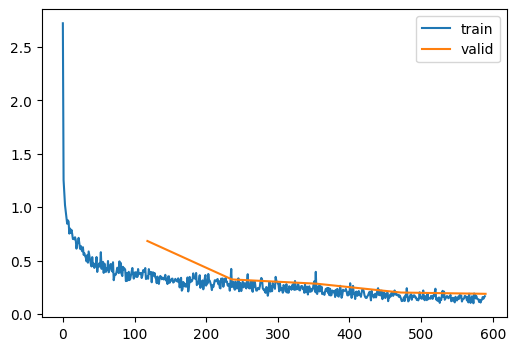

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.1))
transform = nn.Sequential(
    RandSwap(0.15, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[16,64,64,256,256,512,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=partial(optim.AdamW, betas=(0.95, 0.95)))
learn.fit(epochs)

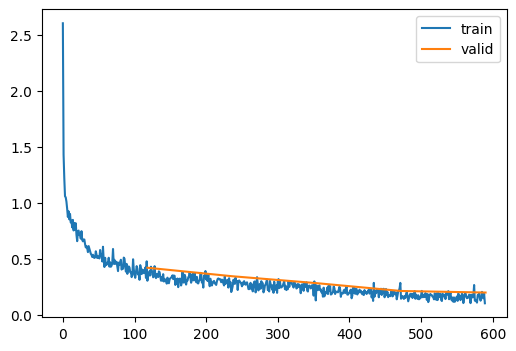

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.15, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
stats = ActivationStats(lambda x: isinstance(x, GeneralReLU))

set_seed(1103, False)
model = get_model(nfs=[16,64,64,256,256,512,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[LsuvCB(),stats,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

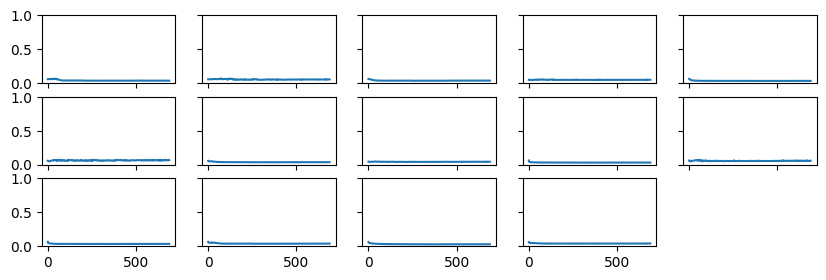

In [ ]:
stats.dead_chart()

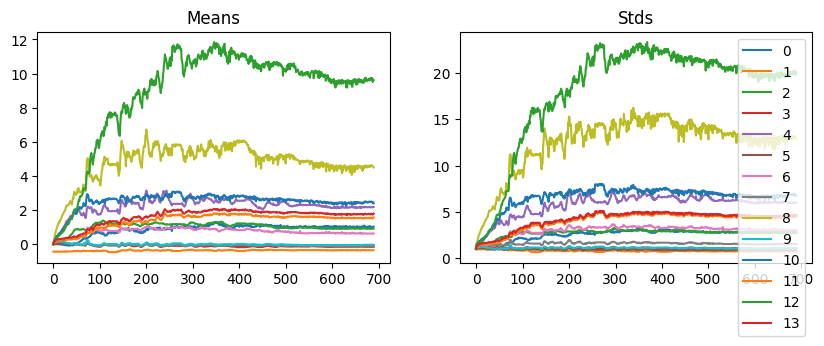

In [ ]:
stats.plot_stats()

In [ ]:
def get_model(act=act_gr, nfs=[16,32,64,128,256,512], norm=nn.BatchNorm2d, p_dropout=0.0, init_zero=False):
    layers = [ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
    layers.append(nn.AdaptiveAvgPool2d(1))
    layers.append(nn.Flatten())
    if p_dropout > 0.:
        layers.append(nn.Dropout(p=p_dropout))
    model = nn.Sequential(
        ResBlock(1, nfs[0], ks=5, stride=1, act=act, norm=norm), *layers,
        nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)
    )
    model = model.apply(init_w)
    if init_zero:
        for l in model[:-5]:
            init.zeros_(l.convs[-1][0].weight)
            init.zeros_(l.convs[-1][0].bias)
    return model

In [ ]:
def get_to_init(model):
    weights, acts = [], []
    for rb in model[:-5]:
        if isinstance(rb.id_conv, nn.Sequential):
            weights.append(rb.id_conv[0])
            acts.append(rb.act)
    return weights, acts

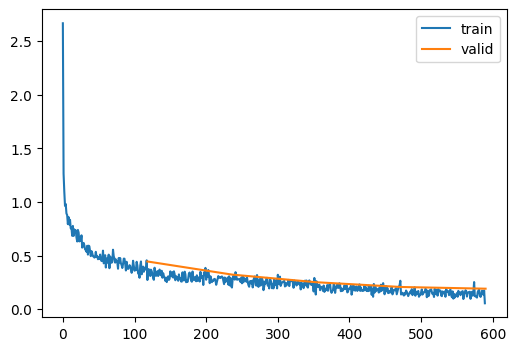

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.15, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
stats = ActivationStats(lambda x: isinstance(x, GeneralReLU))

set_seed(1103, False)
model = get_model(nfs=[16,64,64,256,256,512,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[LsuvCB(*get_to_init(model)),stats,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

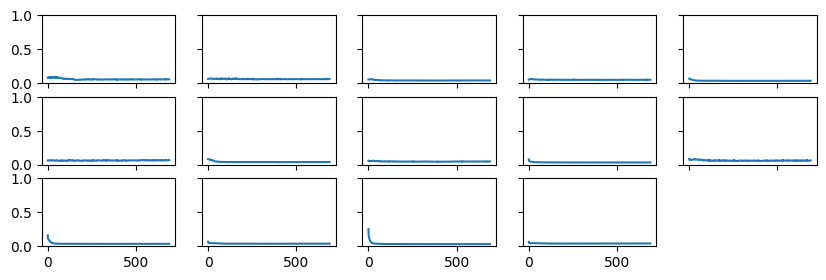

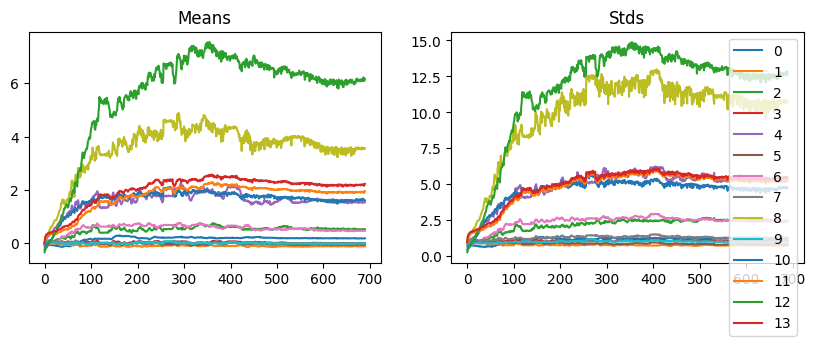

In [ ]:
stats.dead_chart();
stats.plot_stats();

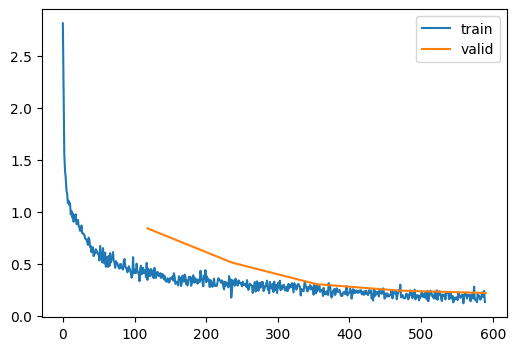

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.15, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
stats = ActivationStats(lambda x: isinstance(x, GeneralReLU))

set_seed(1103, False)
model = get_model(nfs=[16,64,64,256,256,512,512], init_zero=True, p_dropout=0.05)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[LsuvCB(*get_to_init(model)),stats,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

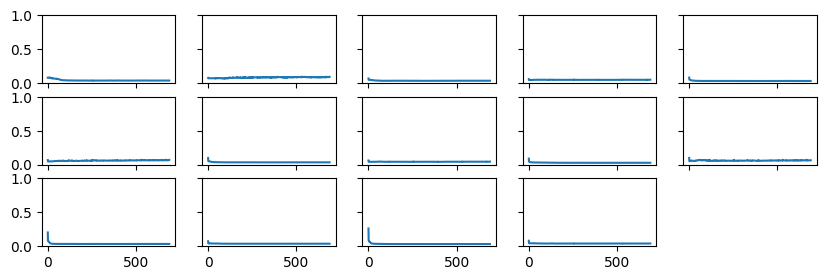

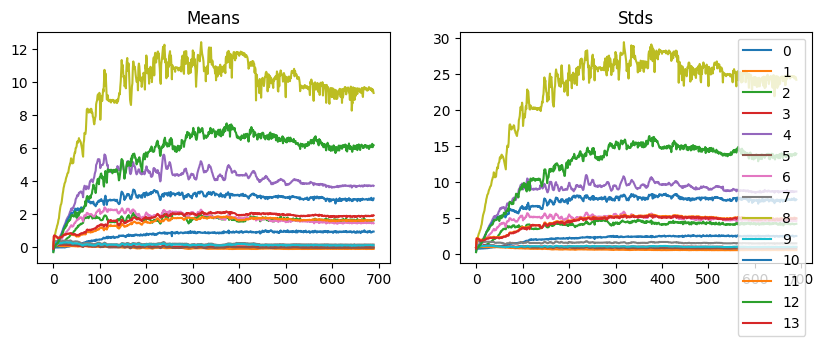

In [ ]:
stats.dead_chart();
stats.plot_stats();

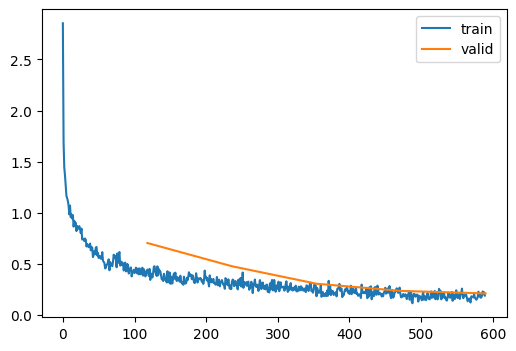

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.15, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[16,256,256,256,256,512], init_zero=True, p_dropout=0.05)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[LsuvCB(*get_to_init(model)),augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

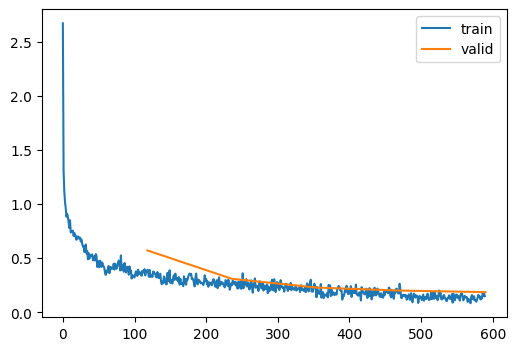

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.15, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[LsuvCB(*get_to_init(model)),augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

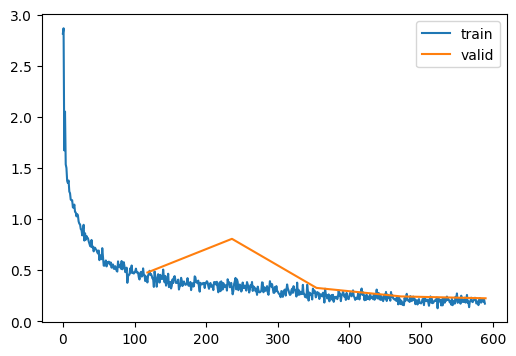

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.15, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[16,256,256,256,256,512], init_zero=True, p_dropout=0.05)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

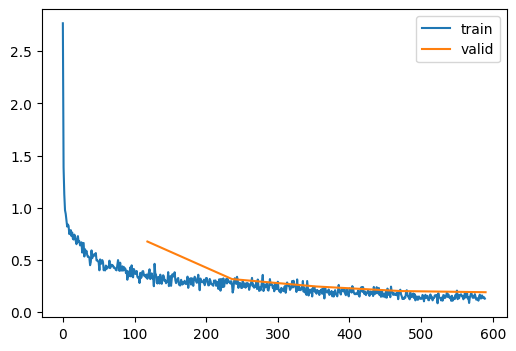

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.15, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

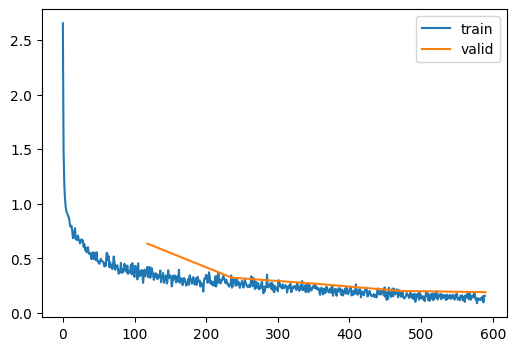

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.15, 1)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[32,256,256,256,256,256], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

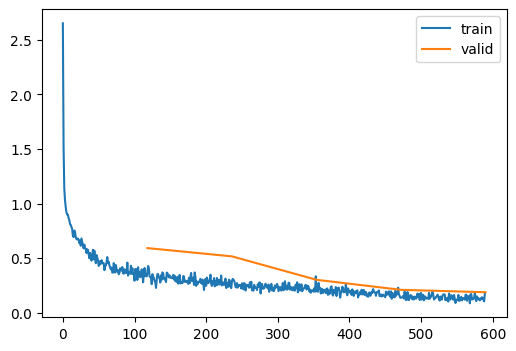

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[32,256,256,256,256,256], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

### Mish

These ideas (mish, curriculum) are from the forum thread (https://forums.fast.ai/t/a-challenge-for-you-all/102656).

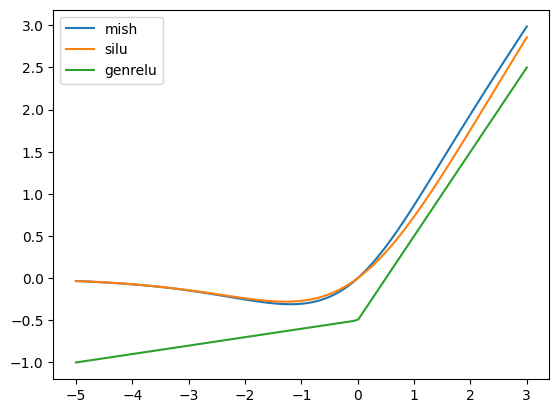

In [ ]:
xs = torch.linspace(-5, 3, 100)
plt.plot(xs, F.mish(xs), label="mish")
plt.plot(xs, F.silu(xs), label="silu")
plt.plot(xs, act_gr()(xs), label="genrelu")
plt.legend();

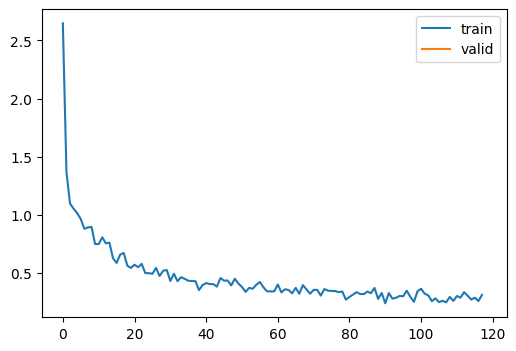

In [ ]:
epochs = 1
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
stats = ActivationStats(mod_filter=lambda x: isinstance(x, nn.Mish))

set_seed(1103, False)
model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[stats,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

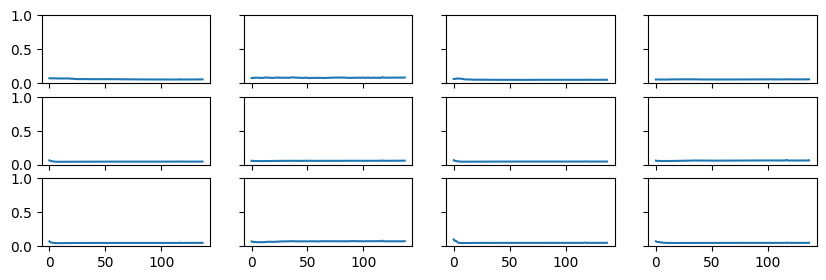

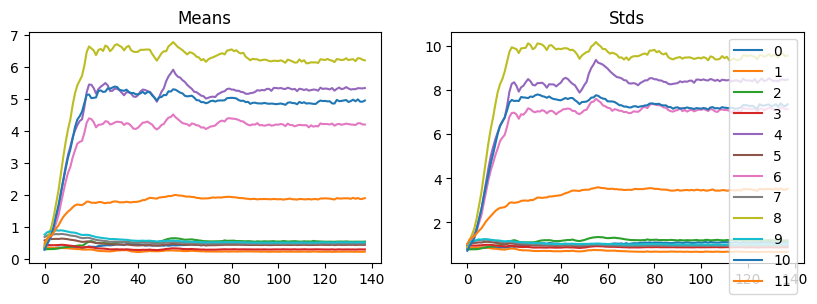

In [ ]:
stats.dead_chart();
stats.plot_stats();

In [ ]:
def get_model(act=act_gr, nfs=[16,32,64,128,256,512], norm=nn.BatchNorm2d, p_dropout=0.0, init_zero=False, leak=0.0003):
    layers = [ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
    layers.append(nn.AdaptiveAvgPool2d(1))
    layers.append(nn.Flatten())
    if p_dropout > 0.:
        layers.append(nn.Dropout(p=p_dropout))
    model = nn.Sequential(
        ResBlock(1, nfs[0], ks=5, stride=1, act=act, norm=norm), *layers,
        nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)
    )
    model = model.apply(partial(init_weights, leak=leak))
    if init_zero:
        for l in model[:-5]:
            init.zeros_(l.convs[-1][0].weight)
            init.zeros_(l.convs[-1][0].bias)
    return model

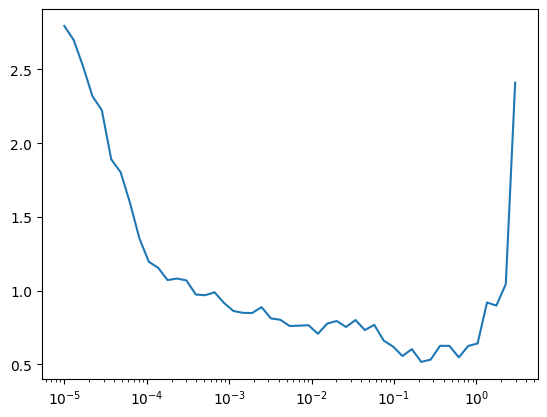

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomCrop(size=30, padding=1),
    RandSwap(0.1, 2)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
stats = ActivationStats(mod_filter=lambda x: isinstance(x, nn.Mish))

set_seed(1103, False)
model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.1)
TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(),augment], opt_func=optim.AdamW).lr_find()

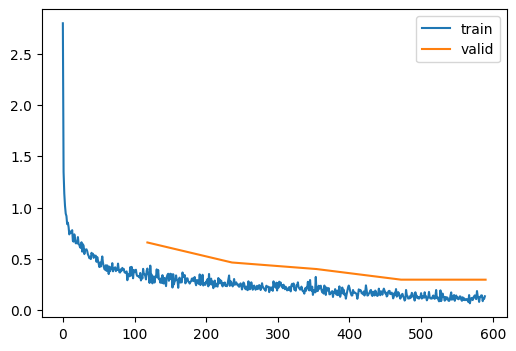

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomCrop(size=30, padding=1),
    RandSwap(0.1, 2)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
stats = ActivationStats(mod_filter=lambda x: isinstance(x, nn.Mish))

set_seed(1103, False)
model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[stats,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

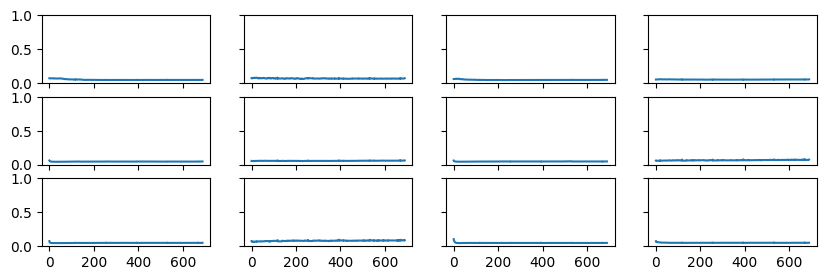

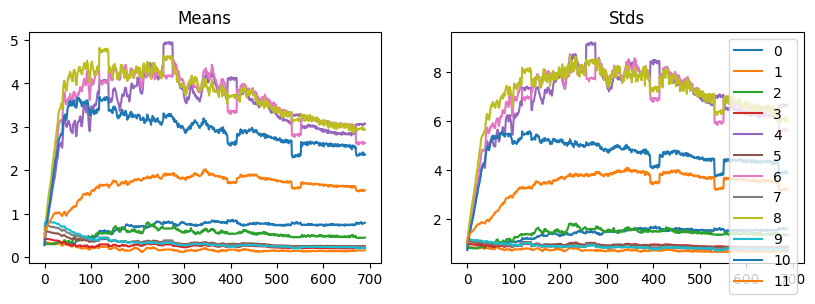

In [ ]:
stats.dead_chart();
stats.plot_stats();

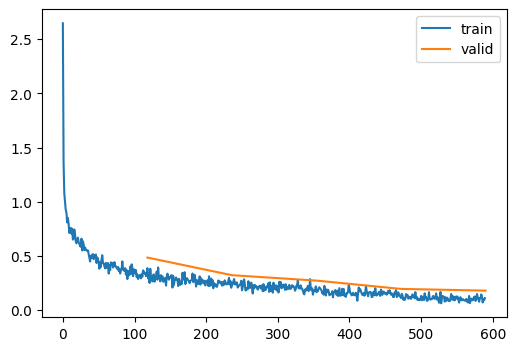

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

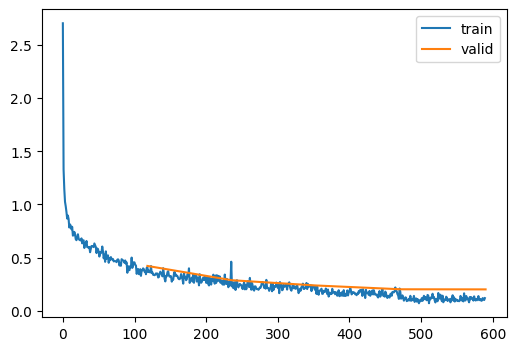

In [ ]:
epochs = 5
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 3)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.2)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

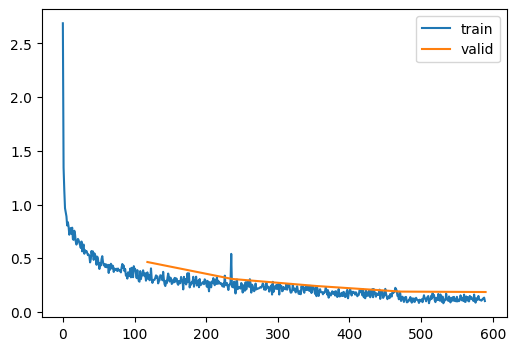

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 3)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.2)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

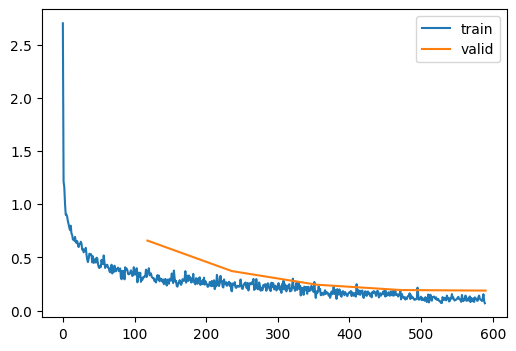

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(act=nn.Mish, nfs=[16,64,256,256,256,256], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

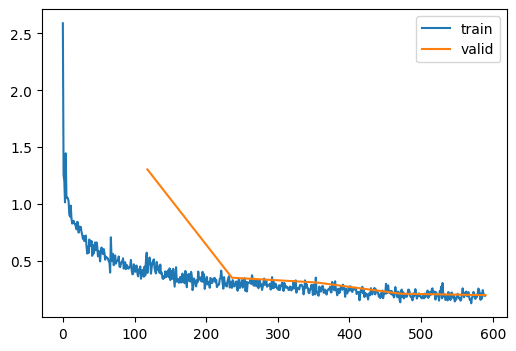

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
    transforms.RandomCrop(size=28, padding=1),
    transforms.RandomHorizontalFlip(),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(act=nn.Mish, nfs=[16,64,256,256,256,256], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

### Label Smoothing

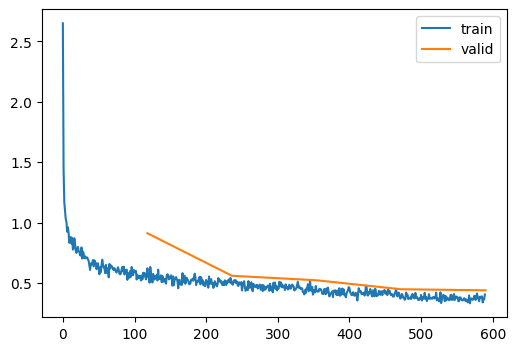

In [ ]:
epochs = 5
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

### Curriculum

In [ ]:
class TopLossesCurriculumCB(Callback):
    def __init__(self, sampler):
        fc.store_attr()
        self.top_losses = [float("inf")] * sampler.num_samples

    def after_batch(self, learn):
        if learn.training:
            losses = to_cpu(F.cross_entropy(learn.preds, learn.batch[1], reduction="none"))
            for idx, loss in enumerate(losses):
                self.top_losses[self.sampler.sampled[idx]] = loss
            self.sampler.sampled = []
    
    def after_epoch(self, learn):
        if learn.training:
            self.sampler.reset_order(self.top_losses)

class TopLossesCurriculumSampler(torch.utils.data.RandomSampler):
    def __init__(self, *args, bottom=0.2, **kwargs):
        super().__init__(*args, **kwargs)
        self.bottom = bottom
        self.reset_order(None)
    
    def reset_order(self, top_losses):
        if top_losses is None:
            self.order = torch.randperm(self.num_samples)
        else:
            n = int(len(top_losses)*self.bottom)
            self.order = torch.argsort(torch.tensor(top_losses), descending=True)[:-n].tolist()
            self.order = self.order[:n] + self.order
            self.order = torch.tensor(self.order)[torch.randperm(len(self.order))]
    
    def __iter__(self):
        self.sampled = []
        while True:
            for sample in self.order:
                self.sampled.append(sample)
                yield sample

In [ ]:
set_seed(1103, False)
bs = 8
top_sampler = TopLossesCurriculumSampler(range(32))
top_cb = TopLossesCurriculumCB(top_sampler)
dls = DataLoaders(
    DataLoader(dst["train"], batch_size=bs, collate_fn=collate_dict(dst["train"]), num_workers=0,
               sampler=top_sampler),
    DataLoader(dst["test"], batch_size=bs, collate_fn=collate_dict(dst["test"]), num_workers=0, shuffle=False),
)
print(top_sampler.order, len(top_sampler.order))
xb, yb = next(iter(dls.train))
xb.shape, yb.shape

tensor([21,  0, 13, 15,  9,  4, 28, 12,  2,  1, 27, 10,  8,  3, 23, 26, 25,  5, 24, 22, 31, 11, 18, 29, 14, 19, 17,  6,  7, 16, 20, 30]) 32


(torch.Size([8, 1, 28, 28]), torch.Size([8]))

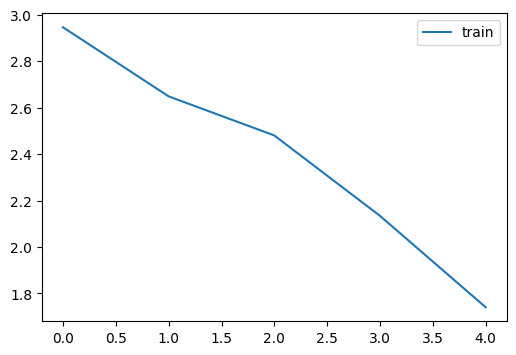

tensor([ 0,  6, 29, 31, 21, 16, 18,  2, 10,  5, 15, 18,  2,  3, 28,  0, 30, 17, 26, 10, 13, 27, 12, 19, 29, 22, 26, 25,  4, 14,  9, 23]) 32
[tensor(3.05), tensor(1.39), tensor(4.36), tensor(1.83), tensor(1.61), tensor(1.73), tensor(2.03), tensor(0.22), tensor(1.14), tensor(2.05), tensor(2.87), tensor(0.88), tensor(1.78), tensor(1.71), tensor(2.09), tensor(2.39), tensor(1.96), tensor(1.66), tensor(2.76), tensor(1.88), tensor(0.52), tensor(1.57), tensor(1.93), tensor(2.36), tensor(1.06), tensor(1.83), tensor(2.64), tensor(2.34), tensor(2.32), tensor(3.65), tensor(1.64), tensor(1.85)]


In [ ]:
epochs = 2
lr = 0.05
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)


model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,sched], opt_func=optim.AdamW)
learn.fit(epochs, valid=False)
print(top_sampler.order, len(top_sampler.order))
print(top_cb.top_losses)

In [ ]:
def get_top_loss_curriculum(bs):
    top_sampler = TopLossesCurriculumSampler(dst["train"])
    top_cb = TopLossesCurriculumCB(top_sampler)
    dls = DataLoaders(
        DataLoader(dst["train"], batch_size=bs, collate_fn=collate_dict(dst["train"]), num_workers=0, sampler=top_sampler),
        DataLoader(dst["test"], batch_size=bs, collate_fn=collate_dict(dst["test"]), num_workers=4, shuffle=False),
    )
    return dls, top_cb

In [ ]:
bs = 512

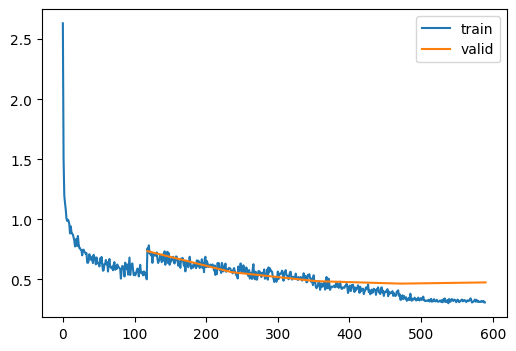

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(bs)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,sched], opt_func=optim.AdamW)
learn.fit(epochs)

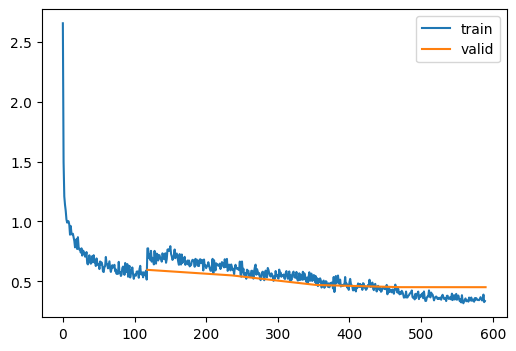

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(bs)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2)
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

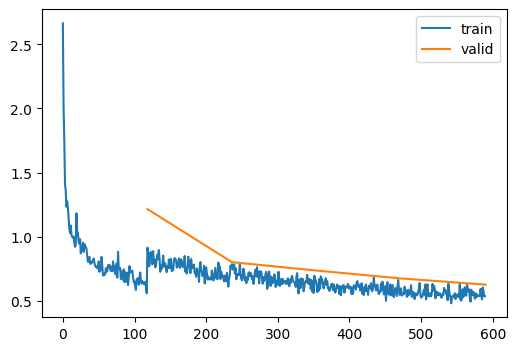

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(bs)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32, scale=(0.9, 1.0), antialias=False),
    RandErase(0.1, 2)
    
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

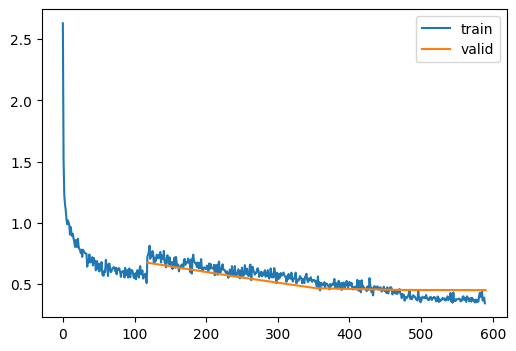

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(bs)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandErase(0.1, 2),
    RandSwap(0.1, 3),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

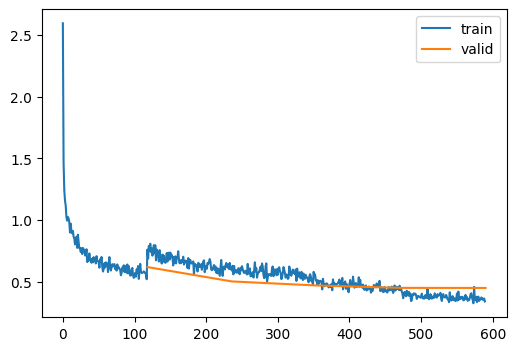

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(bs)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 3),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

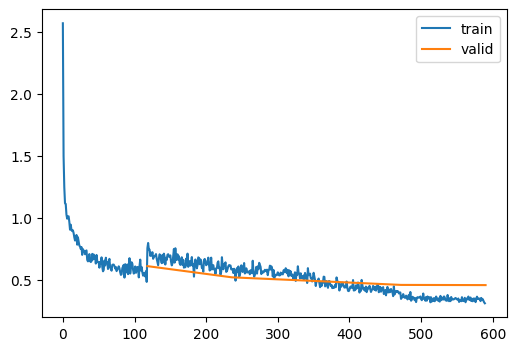

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(bs)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandErase(0.1, 3),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

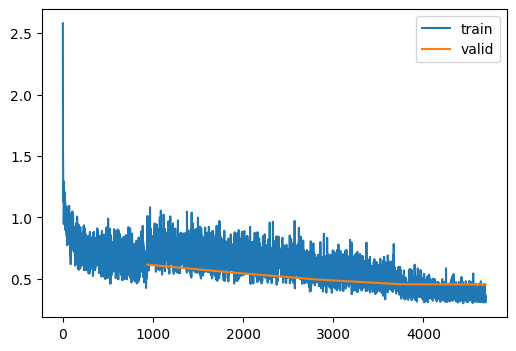

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(64)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

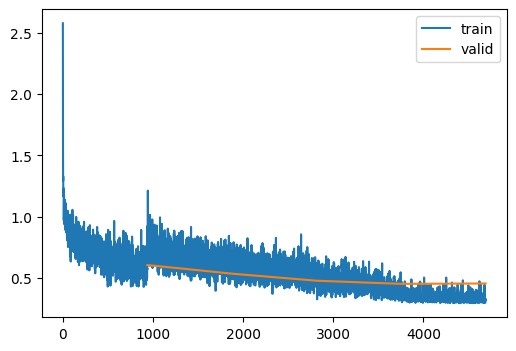

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.01
dls, top_cb = get_top_loss_curriculum(64)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
class TopLossesCurriculumSampler(torch.utils.data.RandomSampler):
    def __init__(self, *args, schedule=[0.2, 0.3, 0.4, 0.5, 0.6], **kwargs):
        super().__init__(*args, **kwargs)
        self.schedule = schedule
        self.cur = 0
        self.reset_order(None)
    
    def reset_order(self, top_losses):
        if top_losses is None:
            self.order = torch.randperm(self.num_samples)
        else:
            if isinstance(self.schedule, float):
                bottom = self.schedule
            else:
                bottom = self.schedule[self.cur]
                self.cur = min((self.cur + 1), len(self.schedule) - 1)
            n = int(len(top_losses)*bottom)
            self.order = torch.argsort(torch.tensor(top_losses), descending=True)[:-n].tolist()
            self.order = self.order[:n] + self.order
            self.order = torch.tensor(self.order)[torch.randperm(len(self.order))]
    
    def __iter__(self):
        self.sampled = []
        while True:
            for sample in self.order:
                self.sampled.append(sample)
                yield sample


def get_top_loss_curriculum(bs, schedule=[0.2,0.3,0.4,0.5,0.6]):
    top_sampler = TopLossesCurriculumSampler(dst["train"], schedule=schedule)
    top_cb = TopLossesCurriculumCB(top_sampler)
    dls = DataLoaders(
        DataLoader(dst["train"], batch_size=bs, collate_fn=collate_dict(dst["train"]), num_workers=0, sampler=top_sampler),
        DataLoader(dst["test"], batch_size=bs, collate_fn=collate_dict(dst["test"]), num_workers=4, shuffle=False),
    )
    return dls, top_cb

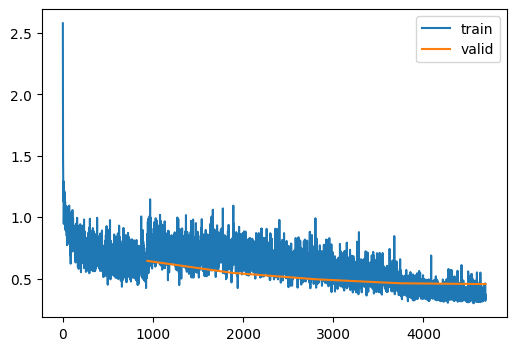

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(64)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

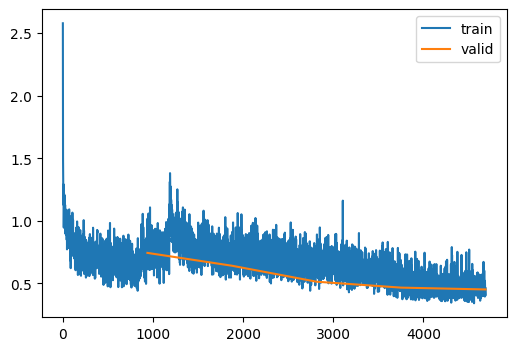

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(64, schedule=[0.1,0.2,0.4,0.4,0.4])
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

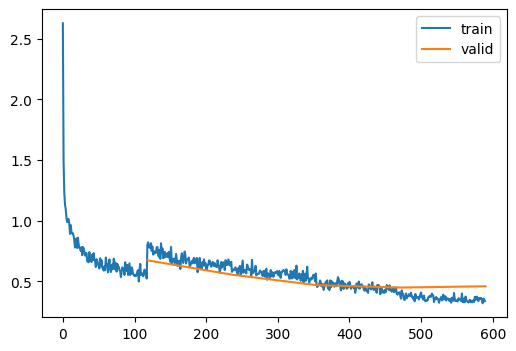

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.3)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

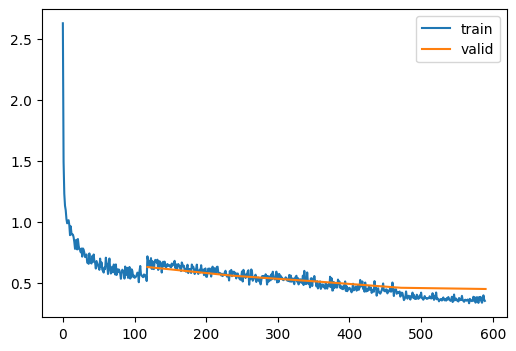

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.1)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

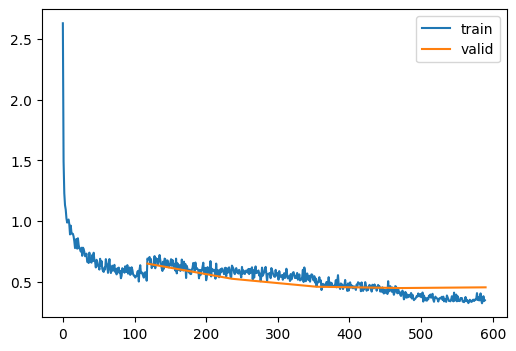

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=[0.1, 0.2, 0.2, 0.25, 0.25])
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

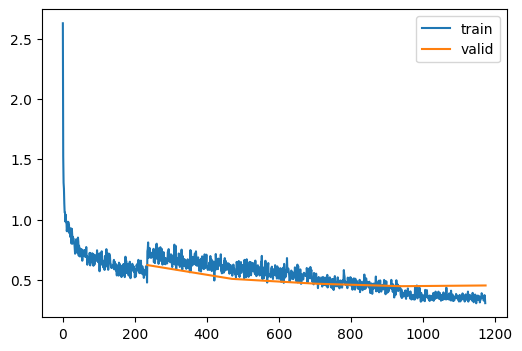

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(256, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

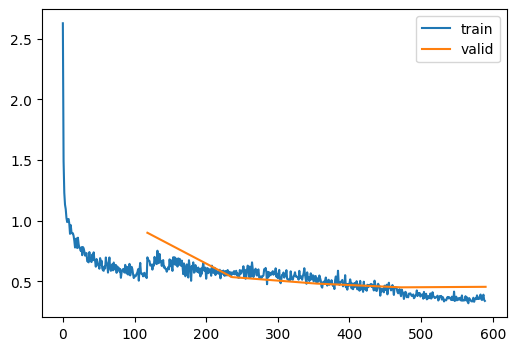

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=[0.1, 0.15, 0.2, 0.25, 0.25])
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

### Trying to simplify and tuning

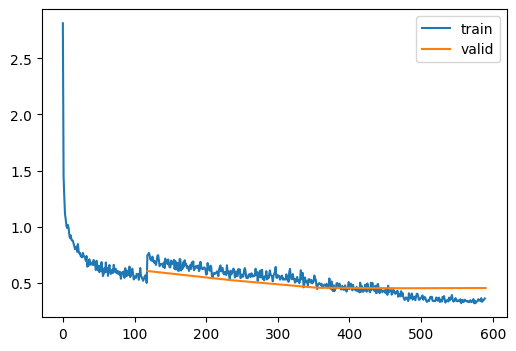

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

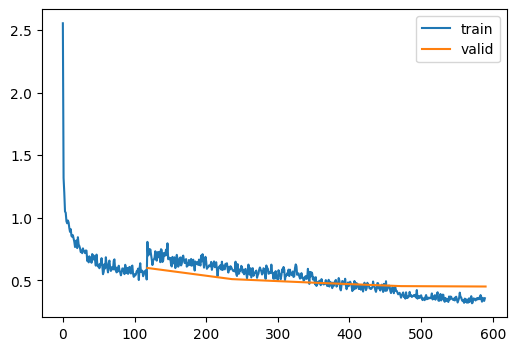

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[32,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

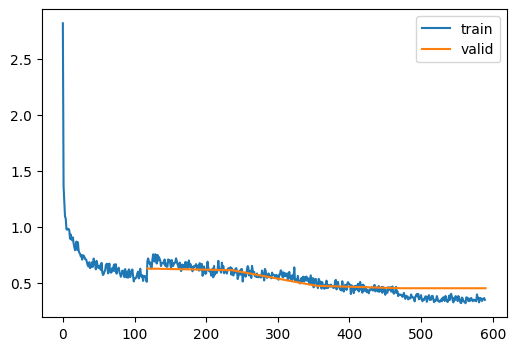

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[32,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

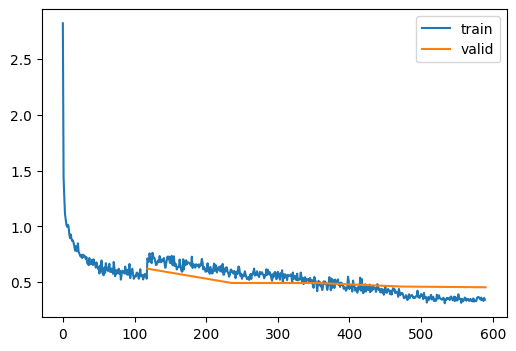

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.0)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

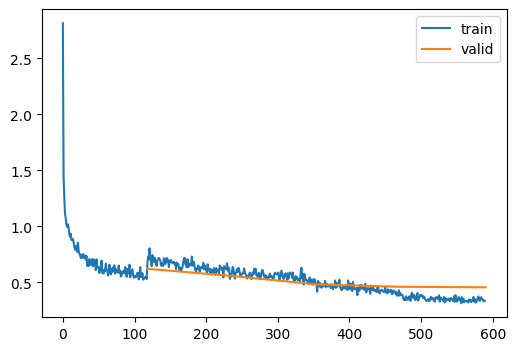

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.1)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

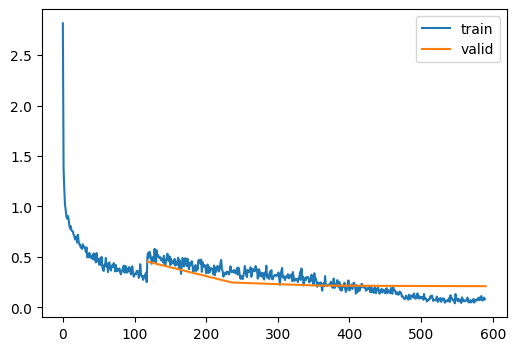

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.0), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

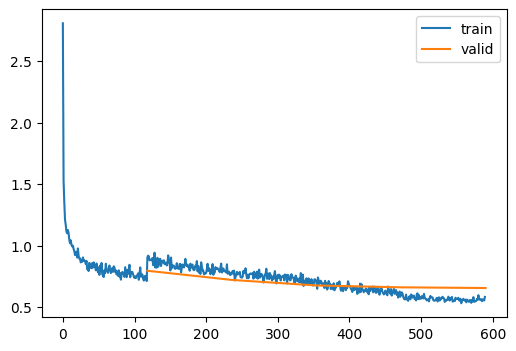

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.1), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

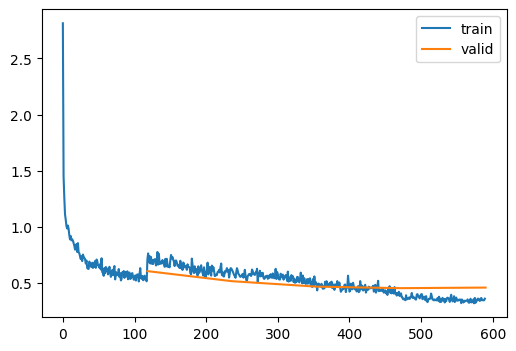

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.1))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

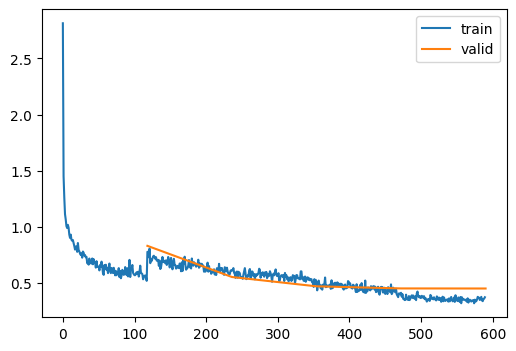

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.2))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

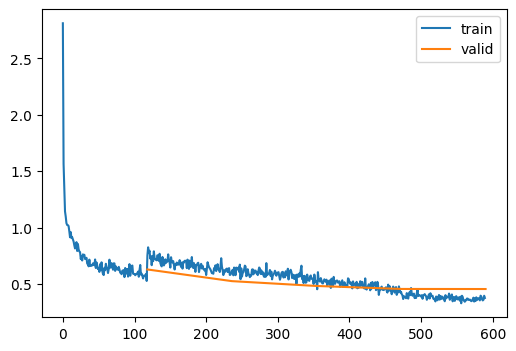

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.1
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

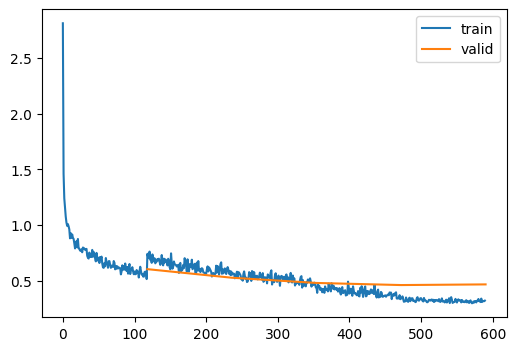

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.01
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

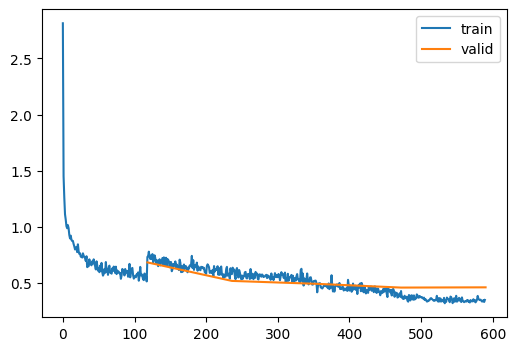

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

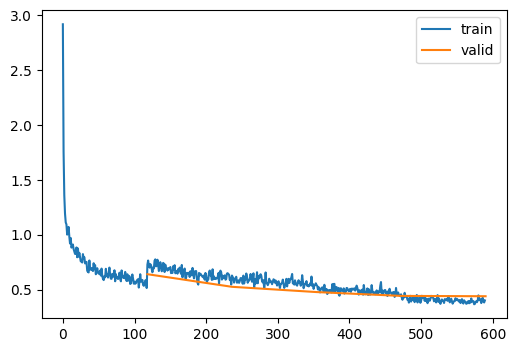

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

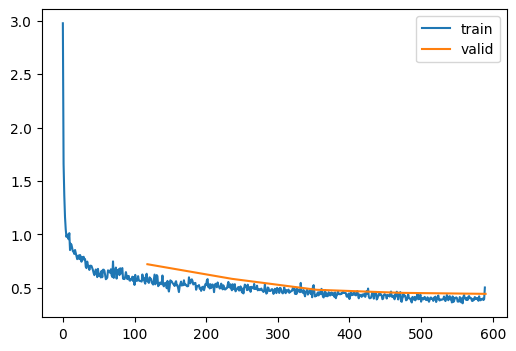

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls = DataLoaders.from_dd(dst, 512)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

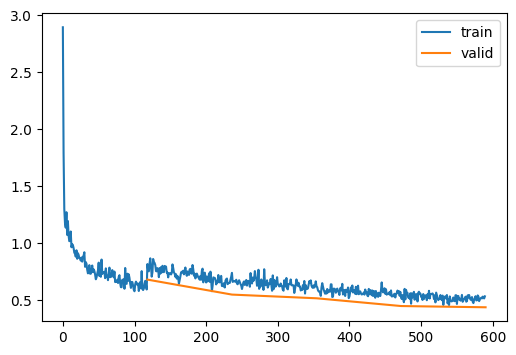

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1),
    transforms.RandomHorizontalFlip(),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

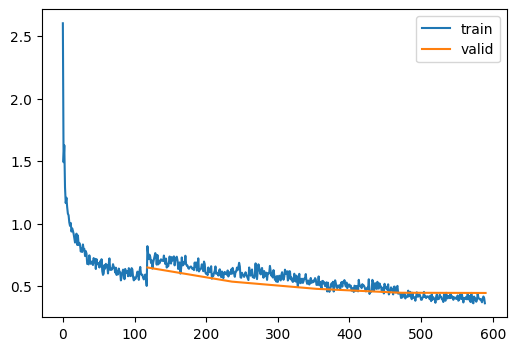

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

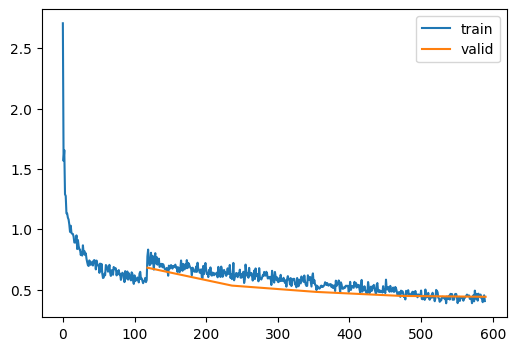

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    RandSwap(0.1, 2),
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

### TTA

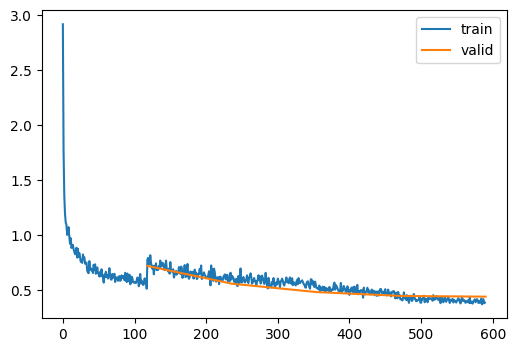

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
def tta_pred(learn):
    aug_tta = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_valid=True)
    
    preds1 = CapturePreds()
    learn.fit(1, cbs=[preds1], train=False)
    preds2 = CapturePreds()
    learn.fit(1, cbs=[preds2, aug_tta], train=False)

    tta_preds = torch.stack((torch.cat(preds1.captured_preds), torch.cat(preds2.captured_preds))).mean(0).argmax(1)
    targets = torch.cat(preds1.captured_targets)
    return (tta_preds == targets).float().mean().item()

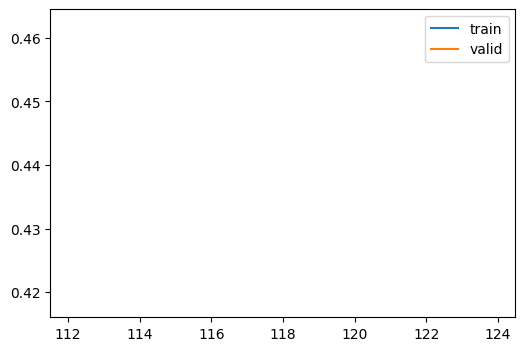

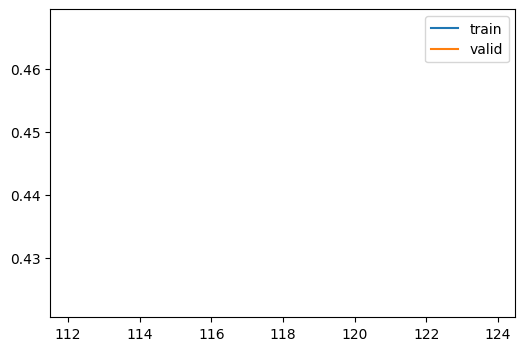

0.9412000179290771

In [ ]:
tta_pred(learn)

### Looking at Top Losses

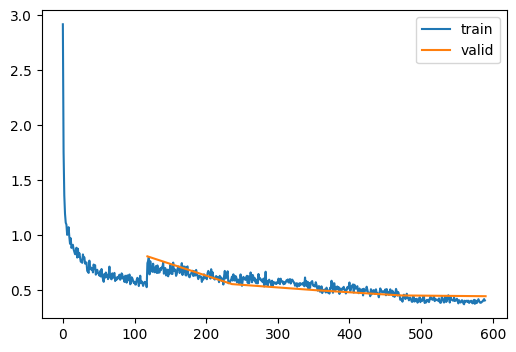

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

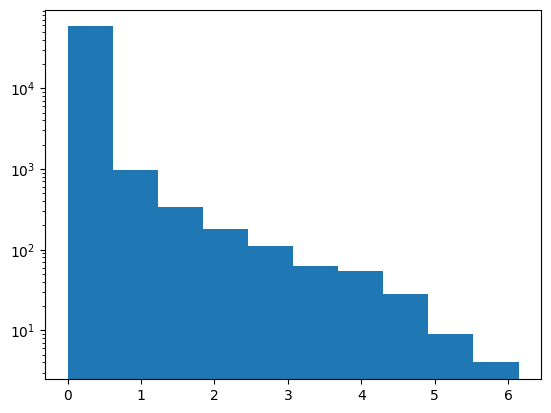

In [ ]:
top_losses = torch.tensor(top_cb.top_losses)
plt.yscale("log")
plt.hist(top_losses);

In [ ]:
(top_losses > 1).sum(), (top_losses > 2).sum(), (top_losses > 3).sum(), (top_losses > 4).sum(), (top_losses > 5).sum()

(tensor(1024), tensor(400), tensor(168), tensor(69), tensor(13))

In [ ]:
top_losses_idxs = torch.argsort(top_losses, descending=True)

In [ ]:
names = dst["train"].features["label"].names

In [ ]:
names

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
def show_top_loss(idxs, **kwargs):
    if isinstance(idxs, int):
        idxs=[idxs]
    images = []
    titles = []
    for idx in idxs:
        example = dst["train"][top_losses_idxs[idx].item()]
        label = f"{top_losses_idxs[idx]}: {names[example['label']]}"
        images.append(example["image"])
        titles.append(label)
    show_images(ims=images, titles=titles, **kwargs)

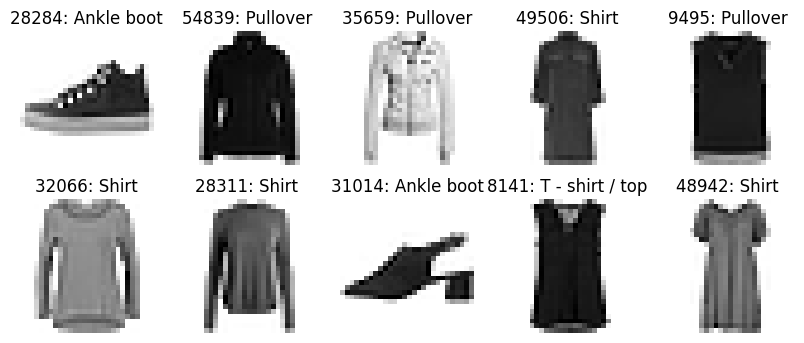

In [ ]:
i = 8
show_top_loss(list(range(i*10, (i+1)*10)), nrows=2, imsize=2)

In [ ]:
new_classes = {
    0: [27350, 25112, 18619, 1087, 16003, 40513, 39525, 33529, 46902, 28764, 33982, 42095, 49712],
    1: [],
    2: [33590, 40513, 13683, 58618, 34456, 169, 43007, 25419, 16971, 44342, 40753, 40342, 44798, 13380, 49983],
    3: [42018, 11885, 16691, 36978, 42288, 15826, 7165, 33760, 7001, 29154, 36049, 53298, 53115, 45592],
    4: [3415],
    5: [],
    6: [],
    7: [38208, 55534, 5427],
    8: [],
    9: [],
    #-1: [51416, 28007, 16361, 42110, 20319, 20544, 9495, 16112, 43195, 54839, 59711, 23363, 13138, 1277, 13365, 2843, 25775, 10084, 44903, 55224, 17243, 14945, 15586]
}
remapping = {}
for k, v in new_classes.items():
    for id in v:
        remapping[id] = k

In [ ]:
from datasets import DatasetDict

In [ ]:
def remap(x, idx):
    if idx in remapping:
        x["label"] = remapping[idx]
    return x

dst_remapped = DatasetDict(ds.copy())
dst_remapped["train"] = ds["train"].map(remap, with_indices=True).filter(lambda x: x["label"] != -1)
dst_remapped = dst_remapped.with_transform(transformi)
dst_remapped, ds

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

(DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 60000
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 60000
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }))

In [ ]:
def get_top_loss_curriculum(bs, ds=dst, schedule=0.2):
    top_sampler = TopLossesCurriculumSampler(ds["train"], schedule=schedule)
    top_cb = TopLossesCurriculumCB(top_sampler)
    dls = DataLoaders(
        DataLoader(ds["train"], batch_size=bs, collate_fn=collate_dict(ds["train"]), num_workers=0, sampler=top_sampler),
        DataLoader(ds["test"], batch_size=bs, collate_fn=collate_dict(ds["test"]), num_workers=4, shuffle=False),
    )
    return dls, top_cb

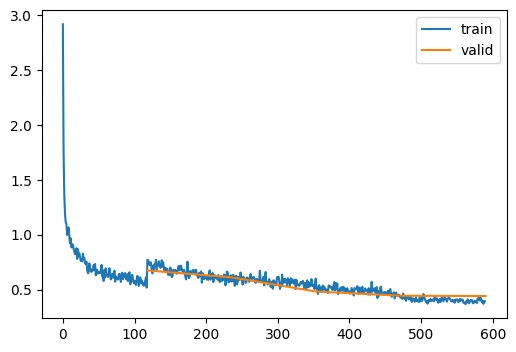

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, ds=dst_remapped, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
new_classes = {
    0: [ # 'T - shirt / top'
        27350, 25112, 18619, 1087, 16003, 40513, 39525, 33529, 46902, 28764, 33982, 42095, 49712, 32685, 8652, 34804, 22212, 30928, 52235, 46125, 57257, 55438, 15532, 18875, 33503, 13803, 25643, 38581, 8097, 17254, 28711, 46902, 56303, 49736, 40981, 32685, 595, 33227, 46261,
        25643, 55905, 40371, 17044, 29652, 57257,  4031, 29487, 49577, 19701, 33503, 12094, 17254, 51598, 316, 34075, 56945, 8943, 24275, 26265, 30360, 14689, 43325, 26500, 18875, 15941, 2708, 39483, 15735, 22212, 26451, 54352
    ],
    1: [ # 'Trouser'
        -1
    ],
    2: [ # 'Pullover'
        33590, 40513, 13683, 58618, 34456, 169, 43007, 25419, 16971, 44342, 40753, 40342, 44798, 13380, 49983, 32070, 51464, 32066, 18942, 30695, 28311, 31778, 40015, 25800, 23053, 12434, 19447, 32052, 22876, 44268, 47546, 11865, 31140, 2467, 33507, 18135, 39218, 9853, 56584,
        38722, 42013, 53928, 31778, 49983, 57213, 14070, 59519, 10086, 6664, 2248, 46310, 16131, 3807, 55018, 51464, 52325, 42314, 33974, 48047, 22750, 32228, 16734, 19091, 21757, 11408, 28264, 24804, 40048, 27714, 55467, 49944, 2079, 19809, 970, 32986, 49412, 55557, 42571,
        21015, 22411
    ],
    3: [ # 'Dress'
        42018, 11885, 16691, 36978, 42288, 15826, 7165, 33760, 7001, 29154, 36049, 53298, 53115, 45592, 28341, 34381, 51735, 43694, 41029, 30945, 18184, 931, 22099, 20811, 2468, 495, 30945, 2843, 21103, 24058, 788, 33254, 43984, 931, 29398, 1642, 38254, 13132
    ],
    4: [ # 'Coat'
        3415, 46259, 4244, 9059, 13138, 11583, 1009, 23446, 50415, 59196, 47597, 13245, 30736, 38049
    ],
    5: [ # 'Sandal'
        -1
    ],
    6: [ # 'Shirt'
        55152, 17606, 39339, 51356, 27869, 36061, 33520, 50349
    ],
    7: [ # 'Sneaker'
        38208, 55534, 5427, 58758, 42691, 14317, 42776, 18392, 5427, 51764, 49978, 32785, 29278, 37688, 25775, 59192, 58758, 10824, 20285, 42982, 29773
    ],
    8: [ # 'Bag'
        -1
    ],
    9: [ # 'Ankle boot'
        56717, 52343, 47163, 9679, 28412, 43194, 47527, 34669
    ],
    -1: [ # '???'
        51416, 28007, 16361, 42110, 20319, 20544, 9495, 16112, 43195, 54839, 59711, 23363, 13138, 1277, 13365, 2843, 25775, 10084, 44903, 55224, 17243, 14945, 15586, 35854, 55829, 39244, 4244, 31654, 30829, 9441, 51852, 51550, 12985, 46259, 25930, 26226, 16799, 31014, 30898,
        2264, 36325, 12340, 20319, 29421, 28961, 19828, 41749, 41910, 40481, 43195, 56042, 56448, 44918, 8060, 48364, 36438, 39139, 33778, 53495, 5838, 51550, 32141, 5171, 56079, 9488, 33467, 26230, 18188, 41675, 21904, 15061, 40032, 7246, 14807, 51436, 31467, 5010, 52041, 13998,
        22689, 59503, 14888, 55431, 33113, 49864, 59298, 42385, 4891, 12391, 50251, 2599, 59667, 4177, 39817, 13233, 16361, 43920, 5608, 38233, 6973, 31333,
    ]
}
remapping = {}
for k, v in new_classes.items():
    print(k, len(v))
    for id in v:
        remapping[id] = k

0 71
1 1
2 80
3 38
4 14
5 1
6 8
7 21
8 1
9 8
-1 101


In [ ]:
def remap(x, idx):
    if idx in remapping:
        x["label"] = remapping[idx]
    return x

dst_remapped = DatasetDict(ds.copy())
dst_remapped["train"] = ds["train"].map(remap, with_indices=True).filter(lambda x: x["label"] != -1)
dst_remapped = dst_remapped.with_transform(transformi)
dst_remapped, ds

(DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 59903
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 60000
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }))

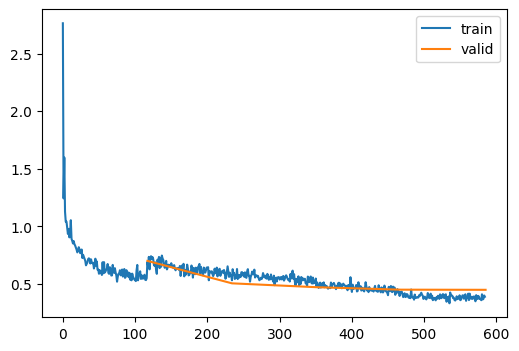

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, ds=dst_remapped, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
def remap(x, idx):
    if idx in remapping and remapping[idx] != -1:
        x["label"] = remapping[idx]
    return x

dst_remapped = DatasetDict(ds.copy())
dst_remapped["train"] = ds["train"].map(remap, with_indices=True).filter(lambda x: x["label"] != -1)
dst_remapped = dst_remapped.with_transform(transformi)
dst_remapped, ds

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

(DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 60000
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 60000
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }))

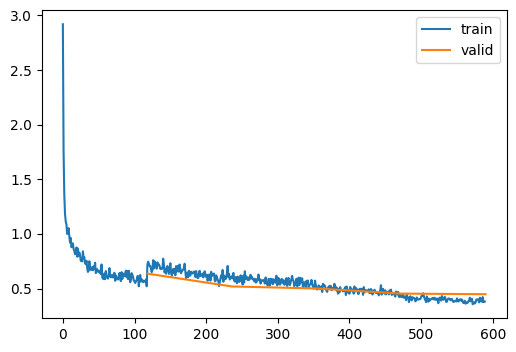

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, ds=dst_remapped, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

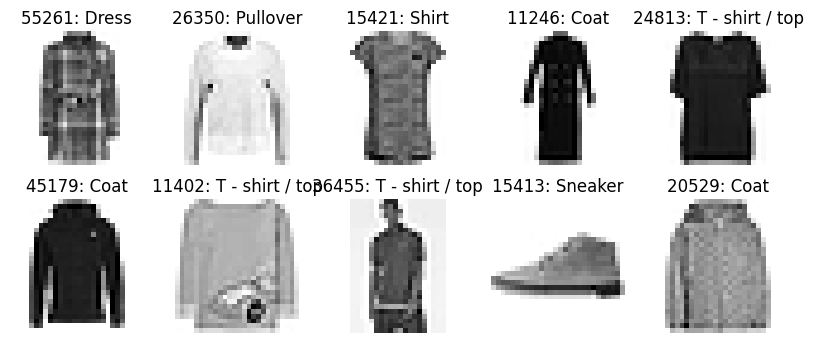

In [ ]:
i = 79
# number 8997 is still wrong
show_top_loss(list(range(i*10, (i+1)*10)), nrows=2, imsize=2)

In [ ]:
new_classes = {
    0: [ # 'T - shirt / top'
        27350, 25112, 18619, 1087, 16003, 40513, 39525, 33529, 46902, 28764, 33982, 42095, 49712, 32685, 8652, 34804, 22212, 30928, 52235, 46125, 55438, 15532, 18875, 33503, 13803, 25643, 38581, 8097, 17254, 46902, 56303, 49736, 40981, 32685, 595, 33227, 46261,
        25643, 55905, 40371, 17044, 29652,  4031, 29487, 49577, 19701, 33503, 12094, 17254, 51598, 316, 34075, 56945, 8943, 24275, 26265, 30360, 14689, 26500, 18875, 15941, 2708, 39483, 15735, 22212, 26451, 54352, 18051, 3298, 50030, 22118, 1600, 37308, 16733,
        30928, 9826, 8330, 14266, 19897, 50198, 19751, 33716, 48647, 9269, 6392, 40124, 10554, 41642, 15353, 36332, 4965, 13497, 4033, 40187, 18442, 42346, 1963, 47328, 55438, 15421, 11661, 8097, 14144
    ], 1: [ # 'Trouser'
        -1
    ], 2: [ # 'Pullover'
        33590, 40513, 13683, 58618, 34456, 169, 43007, 25419, 16971, 44342, 40753, 40342, 44798, 13380, 49983, 32070, 51464, 32066, 18942, 30695, 28311, 31778, 40015, 25800, 23053, 12434, 19447, 32052, 22876, 44268, 47546, 11865, 31140, 2467, 33507, 18135, 39218, 9853, 56584,
        38722, 42013, 53928, 31778, 49983, 57213, 14070, 59519, 10086, 6664, 2248, 46310, 16131, 3807, 55018, 51464, 52325, 42314, 33974, 48047, 22750, 32228, 16734, 19091, 21757, 11408, 28264, 24804, 40048, 27714, 55467, 49944, 2079, 19809, 970, 32986, 49412, 55557, 42571,
        21015, 22411, 55010, 923, 30695, 55743, 56192, 7200, 42082, 33638, 5347
    ], 3: [ # 'Dress'
        42018, 11885, 16691, 36978, 42288, 15826, 7165, 33760, 7001, 29154, 36049, 53298, 45592, 28341, 34381, 43694, 41029, 30945, 18184, 931, 22099, 20811, 2468, 495, 30945, 2843, 21103, 24058, 788, 33254, 43984, 931, 29398, 1642, 38254, 13132, 55536, 46457,
        20179, 28007, 11140, 28573, 830, 46254, 17363, 28007
    ], 4: [ # 'Coat'
        3415, 46259, 4244, 9059, 13138, 11583, 1009, 23446, 50415, 59196, 47597, 13245, 30736, 38049, 8008, 31838, 18202, 20738, 37154, 42110
    ], 5: [ # 'Sandal'
        -1
    ], 6: [ # 'Shirt'
        55152, 17606, 39339, 51356, 27869, 36061, 33520, 50349, 55152
    ], 7: [ # 'Sneaker'
        38208, 55534, 5427, 58758, 42691, 14317, 42776, 18392, 5427, 51764, 49978, 32785, 29278, 37688, 25775, 59192, 58758, 10824, 20285, 42982, 29773, 55071, 19489, 17721, 32926, 57068, 29322, 42584, 43632, 58136, 55694, 54652, 14317, 25775,  14945
    ], 8: [ # 'Bag'
        -1
    ], 9: [ # 'Ankle boot'
        56717, 52343, 47163, 9679, 28412, 43194, 47527, 34669, 14927, 56717, 46100
    ], -1: [ # '???'
        20544, 59711, 23363, 17243, 15586, 35854, 55829, 31654, 9441, 51852, 51550, 46259, 26226, 2264, 40481, 56042, 48364, 36438, 39139, 51550, 56079, 9488, 33467, 26230, 18188, 41675, 21904, 15061, 40032, 7246, 14807, 31467, 52041, 59503, 8302, 1562, 6047,
        33113, 49864, 59298, 42385, 2599, 5608, 6973, 47506, 49644, 44826, 57507, 48756, 41217, 8191, 50648, 2144, 53115, 8910, 50766, 23171, 1862, 13386, 51114, 1369, 44811, 52298, 26533, 44120, 21290, 4307, 38132, 15701, 50651, 41029, 57971, 10656, 5442, 58933,
        13384, 3234, 46949, 2987, 11402, 43325, 57257, 28711, 51735
    ]
}
remapping = {}
for k, v in new_classes.items():
    print(k, len(v))
    for id in v:
        remapping[id] = k

0 103
1 1
2 89
3 46
4 20
5 1
6 9
7 35
8 1
9 11
-1 84


Ankle boot


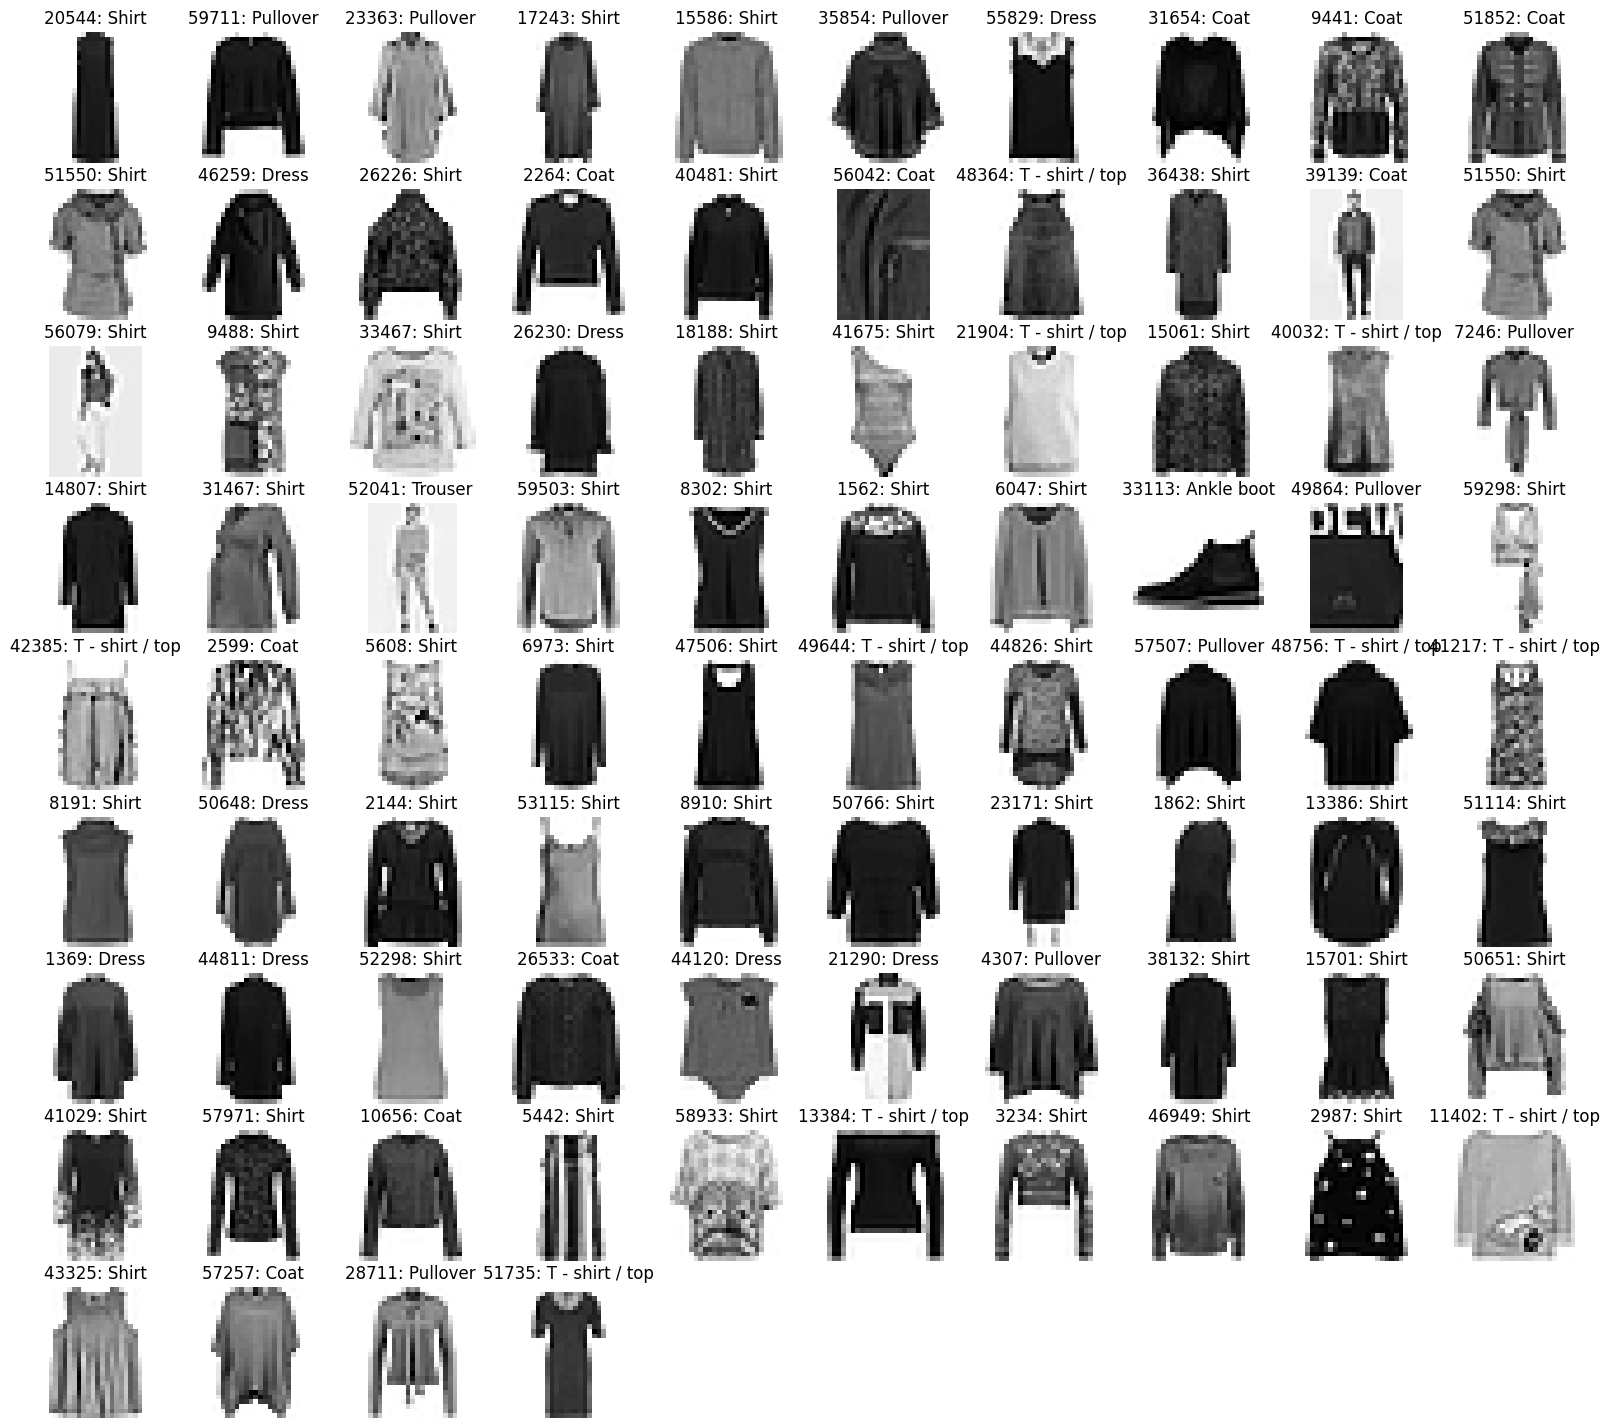

In [ ]:
def showrem():
    cls = -1
    tmp = new_classes[cls]
    imgs = []
    labels = []
    for idx in tmp:
        sample = dst["train"][idx]
        imgs.append(sample["image"])
        labels.append(f"{idx}: {names[sample['label']]}")
    print(names[cls])
    show_images(imgs, titles=labels, nrows=9, imsize=2)
showrem()

In [ ]:
def remap(x, idx):
    if idx in remapping:
        x["label"] = remapping[idx]
    return x

dst_remapped = DatasetDict(ds.copy())
dst_remapped["train"] = ds["train"].map(remap, with_indices=True).filter(lambda x: x["label"] != -1)
dst_remapped = dst_remapped.with_transform(transformi)
dst_remapped, ds

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

(DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 59917
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 60000
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }))

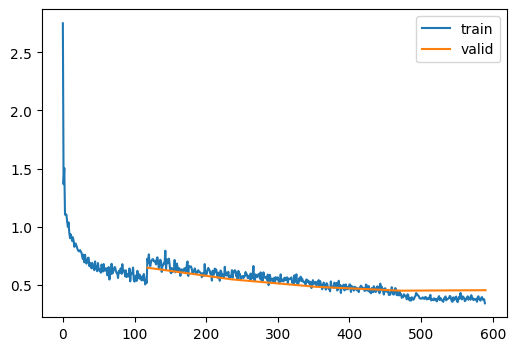

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, ds=dst_remapped, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

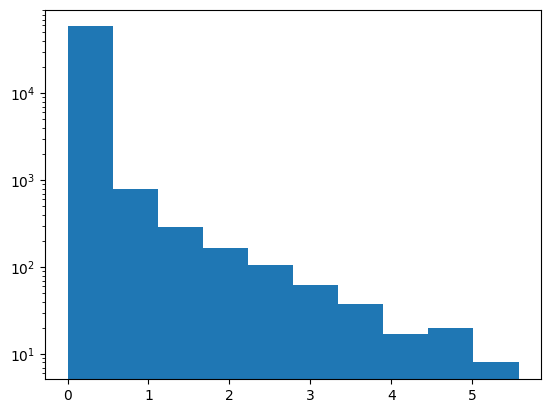

In [ ]:
top_losses = torch.tensor(top_cb.top_losses)
plt.yscale("log")
plt.hist(top_losses);

In [ ]:
(top_losses > 1).sum(), (top_losses > 2).sum(), (top_losses > 3).sum(), (top_losses > 4).sum(), (top_losses > 5).sum()

(tensor(810), tensor(307), tensor(119), tensor(39), tensor(9))

In [ ]:
top_losses_idxs = torch.argsort(top_losses, descending=True)

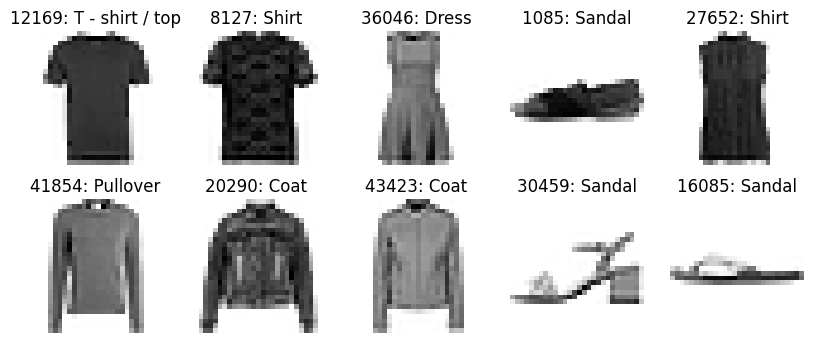

In [ ]:
i = 5
show_top_loss(list(range(i*10, (i+1)*10)), nrows=2, imsize=2)

In [ ]:
def remap(x, idx):
    if idx in remapping and remapping[idx] != -1:
        x["label"] = remapping[idx]
    return x

dst_remapped = DatasetDict(ds.copy())
dst_remapped["train"] = ds["train"].map(remap, with_indices=True).filter(lambda x: x["label"] != -1)
dst_remapped = dst_remapped.with_transform(transformi)
dst_remapped, ds

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

(DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 60000
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 60000
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }))

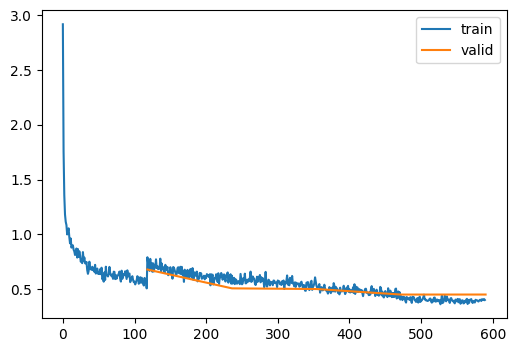

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, ds=dst_remapped, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

#### Just drop

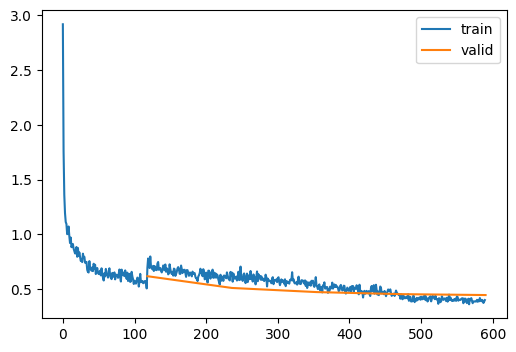

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
top_losses = torch.tensor(top_cb.top_losses)
(top_losses > 4).sum(), (top_losses > 3).sum(), (top_losses > 2).sum(), (top_losses > 1).sum()

(tensor(69), tensor(170), tensor(377), tensor(1017))

In [ ]:
to_drop = top_losses > 1
to_drop.sum()

tensor(1017)

In [ ]:
def remap(x, idx):
    if to_drop[idx]:
        x["label"] = -1
    return x

dst_remapped = DatasetDict(ds.copy())
dst_remapped["train"] = ds["train"].map(remap, with_indices=True).filter(lambda x: x["label"] != -1)
dst_remapped = dst_remapped.with_transform(transformi)
dst_remapped, ds

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

(DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 58983
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 60000
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }))

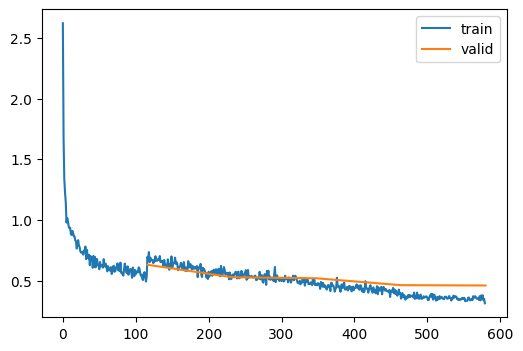

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, ds=dst_remapped, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 59623
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
}) DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


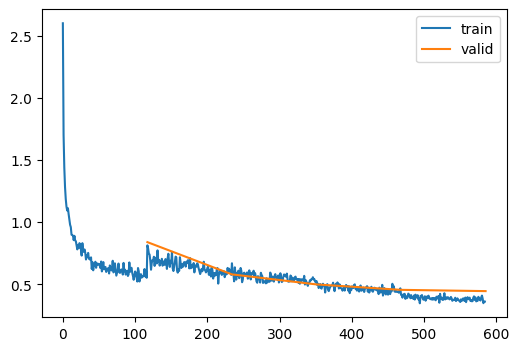

In [ ]:
to_drop = top_losses > 2
to_drop.sum()

def remap(x, idx):
    if to_drop[idx]:
        x["label"] = -1
    return x

dst_remapped = DatasetDict(ds.copy())
dst_remapped["train"] = ds["train"].map(remap, with_indices=True).filter(lambda x: x["label"] != -1)
dst_remapped = dst_remapped.with_transform(transformi)
print(dst_remapped, ds)

set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, ds=dst_remapped, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 59830
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
}) DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


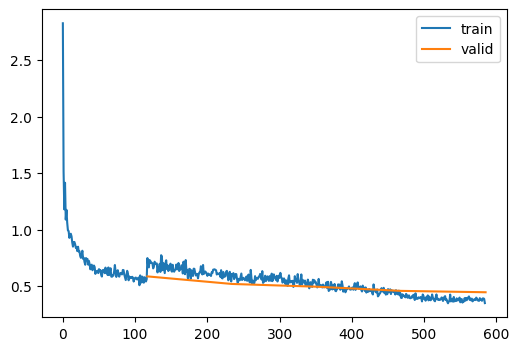

In [ ]:
to_drop = top_losses > 3
to_drop.sum()

def remap(x, idx):
    if to_drop[idx]:
        x["label"] = -1
    return x

dst_remapped = DatasetDict(ds.copy())
dst_remapped["train"] = ds["train"].map(remap, with_indices=True).filter(lambda x: x["label"] != -1)
dst_remapped = dst_remapped.with_transform(transformi)
print(dst_remapped, ds)

set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, ds=dst_remapped, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 59931
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
}) DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


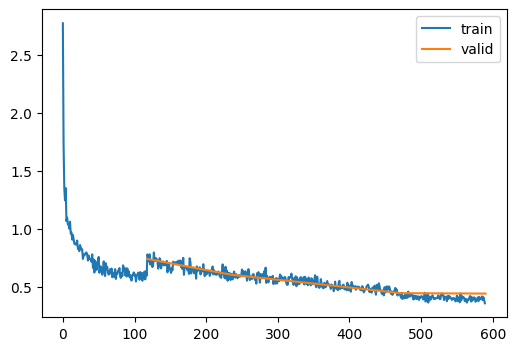

In [ ]:
to_drop = top_losses > 4
to_drop.sum()

def remap(x, idx):
    if to_drop[idx]:
        x["label"] = -1
    return x

dst_remapped = DatasetDict(ds.copy())
dst_remapped["train"] = ds["train"].map(remap, with_indices=True).filter(lambda x: x["label"] != -1)
dst_remapped = dst_remapped.with_transform(transformi)
print(dst_remapped, ds)

set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, ds=dst_remapped, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
(top_losses > 4).sort(descending=True)

torch.return_types.sort(
values=tensor([ True,  True,  True,  ..., False, False, False]),
indices=tensor([36978, 41029, 34456,  ..., 20019, 20020, 20021]))

In [ ]:
(top_losses > 4).argsort(descending=True)[:(top_losses > 4).sum()]

tensor([36978, 41029, 34456, 37962, 37703, 12706, 35223, 11036, 42395, 20842, 34381, 46125, 28341, 16691,  1087, 40513, 40187, 58618, 39620, 56683, 28635, 16350, 44798, 18875,
        33590, 42110, 42018,  9495, 33982, 40015, 43195,  9588, 32066, 25372, 28764, 30206, 16528,  2468, 44342, 55829, 27550, 19086, 13365, 49712, 46211,  7165, 13103,  2843,
        34598, 12190, 26226, 11885, 58341, 43248, 13380, 54839, 27350,  7001,  1106, 16003, 13138, 40753, 20487, 20858, 25419, 55534, 15955, 56601, 16747])